# DAE for Plasma Dignostic

Plasma accelerator is one of the important tools in science, plasma acceleration has made great progress and promises a cheaper in a smaller scale acceleration.  Considering the fact that plasma wake-field acceleration is working based on the plasma wave oscillation, having a clear knowledge of plasma frequency is a crucial part of the PWFA to avoid decelerating. Fortunately, due to the dependency of plasma frequency on the plasma density, by investigation on plasma density using the stark broadening, a clear knowledge of plasma frequency would be achievable. 

However, measuring the plasma density by spectrometer is not always easy, sometimes due to the bad alignment of mirrors and lenses, or due to the low applied voltage on the plasma, the result is noisy, and measuring the denisty is challenging. 



In this project, we want to use the Neural network, to denoise the low voltage results by learning from the result of high voltage which usually are more clean and visible.


In [3]:
# Importing all the important libraries

import matplotlib.pyplot as plt   
import numpy as np
from PIL import Image
import skimage
import os
from scipy.optimize import curve_fit

import random
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader,random_split
import torch.nn.functional as F
import torch.optim as optim
from torch import nn
import torchsummary

# The Neural Network Architecture
Autoencoder is a self-supervised neural network( No need of labels) using for Dimensionality reduction, feature extraction and denoising of data.
It mainly contains two parts, Encoder that compresses the data into the latent code and Decoder decompress it and reconstructs the original input. 
Here, we build our model, both Encoder and Decoder




# Encoder
we apply three 2D convolutions, BatchNormalisation, flatten and two linear layers and The rectified linear activation function.
  
2D Convolution is reduces the images into a form which is easier to process, without losing features which are critical for getting a good prediction. it applies a filter(Kernel) that shifts based on the stride value until the entire image is traversed.

The rectified linear activation function[ how the weighted sum of the input is transformed into an output ] is a simple calculation that returns the value provided as input directly, or the value 0.0 if the input is 0.0 or less.
Since we are dealing with Images , Tanh is not a good choice for activation function, while for our case we can use the Sigmoid since the number of pixels are between[0,1] in our case. however, unsaturated function is always better choice.

Batch Norm: Its job is to take the outputs from the first hidden layer and normalize them before passing them on as the input of the next hidden layer. the gradient descent will converge better during training.

To apply a linear layer after a convolutional one you should convert your tensor to a monodimensional array by a Flatten layer which flatten our pooled feature map into a column.

Linear layers  gives us an average rate of correlation between the output and the input.

In [2]:
# defining our encoder layers

# we apply three 2D convolutions, BatchNormalisation, flatten and two linear layers and The rectified linear activation function

class Encoder(nn.Module):
    
    def __init__(self, encoded_space_dim):
        super().__init__()
        
        ### Convolutional section
        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(1, 8, 3, stride=2, padding=1),  # The formula for calculating the output size  (W-F+2P)/S + 1
            # we have 1 channel as input we want 8 as out put, the kernel size is 3*3 and the stride is 2, and the output is (128*512) from input (256*1024)
            nn.ReLU(True),
            nn.Conv2d(8, 16, 3, stride=2, padding=1), # we have 8 channel as input we want 16 as out put, the kernel size is 3*3 and the stride is 2, and the output is (64*256)
            nn.BatchNorm2d(16),   # BatchNormalisation makes sure that the values of hidden units have standardized mean and variance
            nn.ReLU(True),   
            nn.Conv2d(16, 32, 3, stride=2, padding=0),   # we have 16 channel as input we want 32 as out put, the kernel size is 3*3 and the stride is 2, and the output is (31*127)
            nn.ReLU(True)
        )
        
        ### To apply a linear layer after a convolutional one you should convert your tensor to a monodimensional array by a Flatten layer  
        self.flatten =nn.Flatten(start_dim=1)   # dimension 0 is the sample, so we flatten from dimension 1
           
       
        ### Linear section
        self.encoder_lin = nn.Sequential(
        nn.Linear(32*31*127, 128),       
        nn.ReLU(True),
        nn.Linear(128, encoded_space_dim)
        )
        
    def forward(self, x):
        x = self.encoder_cnn(x)
        x = self.flatten(x)
        x = self.encoder_lin(x)
        return x


# Decoder 

In [3]:
# defining our decoder layers

# we implement a decoder as a reversed encoder architecture, so we have two linear layers , one unflatten, and three up-scaling 2D Convolutions with the activation function

class Decoder(nn.Module):
    
    def __init__(self, encoded_space_dim):
        super().__init__()
        ## Linear
        self.decoder_lin = nn.Sequential(
            nn.Linear(encoded_space_dim, 128),
            nn.ReLU(True),
            nn.Linear(128, 32*31*127),
            nn.ReLU(True)
        )
        ## Unflatten
        self.unflatten = nn.Unflatten(dim=1, 
        unflattened_size=(32,31,127))
        
       ##Transposed Convolutions
        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, 
            stride=2, output_padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 3, stride=2, 
            padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 3, stride=2, 
            padding=1, output_padding=1)
        )
        
    def forward(self, x):
        x = self.decoder_lin(x)
        x = self.unflatten(x)
        x = self.decoder_conv(x)
        x = torch.sigmoid(x)
        return x

# Initiallizing the Network & Training 

At each iteration weights are updated according to learning rate parameters( defines the magnitude of the vector modification) by optimizer.

Adam: RMSProp + momentum, by default is the best optimizer

Loss Function: quantifies the difference between the expected outcome and the outcome produced by the machine learning model.

In [4]:
### Set the random seed for reproducible results
torch.manual_seed(0)

# Initiallizing the networks

encoded_space_dim=1  # since, our image files have image mode " I ", they have only one dimension 
encoder = Encoder(encoded_space_dim=encoded_space_dim)
decoder = Decoder(encoded_space_dim=encoded_space_dim)

### Define the loss function 
# MSE stands for mean square error which is the most commonly used loss function
loss_fn = torch.nn.MSELoss()

### we defined the Adam optimizer for both encoder and decoder
lr = 1e-2
params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]
optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-5)

# Check the available device
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(' The device is **{}**'.format (device))



# printing a summary of NN network encoder and the decoder to the selected device 
print(encoder.to(device))
print(decoder.to(device))
print(torchsummary.summary(encoder.to(device),(1,256,1024)))


 The device is **cuda**
Encoder(
  (encoder_cnn): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU(inplace=True)
    (5): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (6): ReLU(inplace=True)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (encoder_lin): Sequential(
    (0): Linear(in_features=125984, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=1, bias=True)
  )
)
Decoder(
  (decoder_lin): Sequential(
    (0): Linear(in_features=1, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=125984, bias=True)
    (3): ReLU(inplace=True)
  )
  (unflatten): Unflatten(dim=1, unflattened_size=(32, 31, 127))
  (decoder_conv): Sequential(
    

# Training Function 

NN takes place in two distinct phases which are repeated at each iteration:

• forward phase: the weights are fixed and the input vector is propagated layer by layer up to the output neurons.

• backward phase: the Δ error is calculated by comparing the output with the target y and the result is propagated back, again layer by layer (error signal).

In [5]:
### Training function will train the network for each epoch
def train_epoch_den(encoder, decoder, device, dataloader, loss_fn, optimizer,noise_fac):
    # Set train mode for both the encoder and the decoder
    encoder.train()
    decoder.train()
    train_loss = []
    
    for img in dataloader: #for each batch  in the data loader, it adds noise and then send it to network
        # add the gaussian noise and move tensor to the proper device
        image_noisy =noise_maker(img,noise_fac).to(device)
        main_image = img.to(device)   # keep the main image for evaluate the loss
        # Encode data
        encoded_data = encoder(image_noisy)
        # Decode data
        decoded_data = decoder(encoded_data)
        # Evaluate loss
        loss = loss_fn(decoded_data, main_image)
        # Backward pass
        optimizer.zero_grad()   # to empty the value in gradiant attribute
        loss.backward()
        optimizer.step()
        # Print batch loss
        print('Partial Train loss is {}'.format(loss.data))
        train_loss.append(loss.detach().cpu().numpy()) #keeping all the losses as np array

    return np.mean(train_loss)

# Validation function

In [6]:
### Validation function to evaluate how well we are reproducing the input

def vali_epoch_den(encoder, decoder, device, dataloader, loss_fn,noise_fac):
    # Set evaluation mode for encoder and decoder
    encoder.eval()
    decoder.eval()
    with torch.no_grad(): # No need to track the gradients
        # Define the lists to store the outputs and inputs for each batch
        after = []
        before = []
        for img in dataloader:
            # Add noise and move the tensor to the proper device
            image = noise_maker(img,noise_fac).to(device)
            # Encode data
            encoded_data = encoder(image)
            # Decode data
            decoded_data = decoder(encoded_data)
            # Append the network output and the original image to the lists
            after.append(decoded_data.cpu())
            before.append(img.cpu())
        # Create a single tensor with all the values in the lists
        after = torch.cat(after)
        before = torch.cat(before) 
        # Evaluate global loss
        val_loss = loss_fn(after,before)
        print(' \n Global  validation loss for this epoch  is {} '.format(val_loss.data))
    return val_loss.data

# Noise Function

In [7]:
# define a  function for adding noise to clean data
def noise_maker(inputs,noise_factor): 
    noisy=inputs+torch.randn_like(inputs)*noise_factor # to create a noisy tensor of the same size of the input
    noisy=torch.clamp(noisy,0.,1)  #  to limit the range between 0 and 1
    return noisy


# Initial Data Function

In [8]:
# Initial data function has been defined for plotting the samples that we have, whether the clean and noisy, plus the result of adding the noise 

def compare(clean,train_dataset,noise,noise_factor,rand):
    
    # Here, we add noise to our clean data set, and conver it to numpy for plotting it
    noisy_sam=noise_maker(train_dataset,noise_factor)
    noisy_sam=noisy_sam.cpu().permute(0,2,3,1).squeeze().numpy()
    
    # By defining the range, you can choose how many samples to be shown, in our case it's only one sample
    rangee=1
    for i in range(rangee): 
        plt.subplot(1,3,1)
        plt.imshow(clean[rand+i])   # The first one is clean image
        plt.title('Sample {} of clean data'.format(rand+i))
        plt.subplot(1,3,2)
        plt.imshow(noisy_sam[rand+i])    # the second one is the clean data after adding the noise
        plt.title('Sample {} of clean data with noise'.format(rand+i))
        plt.subplot(1,3,3)
        plt.imshow(noise[rand+i])  # the third one is noisy image that we want to denoise it
        plt.title('Sample {} of noisy data'.format(rand+i))
        plt.subplots_adjust(left=1,
                    bottom=0.1, 
                    right=3, 
                    top=0.9, 
                    wspace=0.1, 
                    hspace=0.2) 
        plt.show()
    
    
    
    
    # Here, we check one of the longitudinal spectrum of our images which we usually use in measuring the plasma density 
    x=np.linspace(0,1024,1024)
    for i in range(rangee):
        plt.subplot(1,3,1)
        plt.plot(x,clean[rand+i][150])     # The first one is spetrum from clean image
        plt.title('Clean spectrum of sample {}'.format(rand+i))
        plt.subplot(1,3,2)
        plt.plot(x,noisy_sam[rand+i][150])     # the second one is the spectrum from clean data after adding the noise
        plt.title('added noise to clean spectrum of sample {}'.format(rand+i))
        plt.subplot(1,3,3)
        plt.plot(x,noise[rand+i][150])  # the third one is the spectrum from noisy image that we want to denoise it
        plt.title('noisy spectrum of sample {}'.format(rand+i))
        plt.subplots_adjust(left=1,
                    bottom=0.1, 
                    right=3, 
                    top=0.9, 
                    wspace=0.1, 
                    hspace=0.2) 
        plt.show()
    

# Initial Results Function

In [9]:
# This function sends the noisy samples to our model, and plot the final results of denoising

def plotting(test_data,encoder,decoder,rand):
    
     # move the tensor to proper device and Set evaluation mode for encoder and decoder
    img = test_data.to(device)
    encoder.eval()
    decoder.eval()
        
    with torch.no_grad(): ## No need to track the gradients
        rec_img  = decoder(encoder(img)) #implement the model
          
     # Preparing the samples and results as numpy array to plot them   
    original=img.cpu().permute(0,2,3,1).squeeze().numpy()
    denoised=rec_img.cpu().permute(0,2,3,1).squeeze().numpy()
    
     # By defining the range, you can choose how many samples to be shown, in our case it's only one sample
    rangee=1   
    # we used the same codes as above to show the final results both for each image and its spectrum
    for i in range(rangee):  
        plt.subplot(1,2,1)
        plt.imshow(original[rand+i],cmap='binary')
        plt.title('Sample {} of  noisy images '.format(rand+i))
        plt.subplot(1,2,2)
        plt.imshow(denoised[rand+i],cmap='binary')
        plt.title('Sample {} of denoised images'.format(rand+i))
        plt.subplots_adjust(left=1,
                    bottom=0.1, 
                    right=3, 
                    top=0.9, 
                    wspace=0.1, 
                    hspace=0.2) 
        
        plt.show()
        
    x=np.linspace(0,1024,1024)
    for i in range(rangee):
        plt.subplot(1,2,1)
        plt.plot(x,original[rand+i][100])
        plt.title(' Spectrum sample {} of Noisy images'.format(rand+i))
        plt.subplot(1,2,2)
        plt.plot(x,denoised[rand+i][100])
        plt.title('Spectrum sample {} of denoised images'.format(rand+i))
        plt.subplots_adjust(left=1,
                    bottom=0.1, 
                    right=3, 
                    top=0.9, 
                    wspace=0.1, 
                    hspace=0.2) 
        plt.show()
   
    return(denoised)

# Final Analysis Function

In [10]:
# This function is defiend to analyse the final images and tries to fit the spectrum by Lorentzian function, and using the Stark-Broadning formula, measure the density and give us the density Profile
# this function has been developed by me and two of my classmates during our lab project ( Chaitanya Varma and Sara Molisani)
# what we do here is 
def main(final):

    Mnd, MCv, MAv, MWv, MPv, MDv, MDl= [],[],[],[],[],[],[]
    for dim in range(len(final)):

        data=final[dim]
        N=len(data)
        lda=np.zeros(N) #array for density value at each transverse section / longitudinal dimenion
        tda=np.zeros(1024) # transverse section dimension

        # Defined set of cuts for a particular image
        c1= 159
        c2= 861

        # Size of the range of pixels in use
        N1= c2-c1

        # Array to work with for an image
        nd=[]
        cval, aval, wval, pval, dval= [],[],[],[],[]

        ## Fitting function details: We use a 3 parameter lorentzian with a push 
        def Lorentzian(x, amp, cen, hw, push):
            return (push+(amp*hw**2/((x-cen)**2+hw**2)))

        xpos=np.linspace(c1,c2,N1+1)      # Array for storing the x-values for fitting

        # Calibration of actual length with pixel size representation
        pixel= 0.072 # transversal calibration 0.072 [nm/pixel]
        alpha= 0.0225    # other alpha was around 0.0918
        LC= 150000 # nm/pixel is the longitudinal calibration


        #plt.figure()
        for i in range(N):

            tda=data[i] 
            ta= []

            for j in range(1024):
                if j>=c1 and j<=c2:
                    ta.append(tda[j])

            hpi=ta.index(max(ta))+c1 # This calculates the value of the index containing the highest point on a row of data
            #print(hpi)
            if (hpi>380 and hpi<460): # condition to reduce misplaced lorentzians
            # We begin fitting the data for each of the rows of pixels for the image
                while True:
                    try:
                        popt, pcov = curve_fit(Lorentzian, xdata= xpos, ydata= ta, p0= [40000, 415, 100, 1700]) # try 415 for cen
                        break
                    except(RuntimeError):
                        popt, pcov = curve_fit(Lorentzian, xdata= xpos, ydata= ta, p0= [35000, 415, 100, 1700], bounds=[(18000, 400, 0, 1000),(50000, 600, 150, 2000)])
                        break
                    else:
                        pass
                #print(popt[0])
                aval.append(popt[0])
                cval.append(popt[1]+c1)
                wval.append(abs(popt[2]*2))
                pval.append(popt[3])
                nd.append(ta)

                delta_lambda = pixel*(abs(popt[2]*2)) #delta of wavelength that we need for Stark formula
                dval.append(8.02*(10**12)*(delta_lambda*10/alpha)**1.5) # density in cm-3

            else: # if highest point is not in the central region we put to zero the values of this transverse section

                aval.append(0)
                cval.append(0)
                wval.append(0)
                pval.append(0)
                nd.append(0)
                dval.append(0) # density in cm-3

        #plt.show()
        # store the values of every image
        Mnd.append(nd)
        MCv.append(cval)
        MAv.append(aval)
        MWv.append(wval)
        MPv.append(pval)
        MDv.append(dval)

    Mnd1= np.asarray(Mnd)
    MCv1= np.asarray(MCv)
    MAv1= np.asarray(MAv)
    MWv1= np.asarray(MWv)
    MPv1= np.asarray(MPv)
    MDv1= np.asarray(MDv)
    return(MDv1, final, N)



def beaut(MDv1, final, N):

    xar= np.linspace(0,254,N)
    lc= 150000*10**(-6) # mm/pixel is the longitudinal calibration
    pos_cal=np.linspace(0,254,N)*lc

    cia=np.zeros([2,N]) # Array to hold values for the mean and the std (from ebm)
    for i in range(N):
        ebm=[] # Array to store values for the error bar measurement
        # For each of the points in the long. dir. of the capillary, we calculate the average density and the std. dev. considering the 50 images
        for j in range(0,len(final)):
            if (MDv1[j][i]>0): #not considering the transv. sections put at zero before
                ebm.append(MDv1[j][i]) 
        cia[0][i]= np.mean(ebm)
        cia[1][i]= np.std(ebm)

    print('Relative error at center of capillary:', cia[1][120]/(2*cia[0][120]))
    s=' capilary 3cmx1mm with delay 1000ns'
    fig, ax = plt.subplots()
    plt.xlabel(' Longitudinal position [mm]')
    plt.ylabel(' Plasma Density [cm-3]')
    plt.text(0,0.8,s,transform=ax.transAxes)
    #plt.text(0,9.4*10**17,s)
    plt.title('Density profile')
    ax.errorbar(pos_cal, cia[0], yerr=cia[1],fmt='.', markersize=1.5, ecolor='black', elinewidth=0.1)
    plt.ylim(0.5*10**17, 4*10**17)
    #plt.axvline(mm)
    plt.savefig('3x1_600A_1500ns_600mb', dpi='figure', format='pdf')
    plt.show()
    

# Since most parts of our Model have been defined, we start to import our data

# Downloading the data



In [5]:
# !wget https://download2280.mediafire.com/jxsxknnqr0vg/v83p8algn0z87nh/all.zip

--2022-06-27 20:28:08--  https://download2280.mediafire.com/jxsxknnqr0vg/v83p8algn0z87nh/all.zip
Resolving download2280.mediafire.com (download2280.mediafire.com)... 199.91.155.21
Connecting to download2280.mediafire.com (download2280.mediafire.com)|199.91.155.21|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 226165284 (216M) [application/zip]
Saving to: 'all.zip'

all.zip             100%[===================>] 215.69M  75.0MB/s    in 2.9s    

2022-06-27 20:28:11 (75.0 MB/s) - 'all.zip' saved [226165284/226165284]



# Importing the data

In [6]:
# If the folder of data exsists, nothing happens, but if we don't have the folder, it will extract the folders

path= r"sagemaker-studiolab-notebooks/AML project/v3.0"
if  os.path.exists('4kv_2500_clean'):
    print('The folders are already there')
else:
    a=!unzip all.zip



In [7]:
# Importing the images seperately for noisy and clean one
    
clean= []
for fname in os.listdir('4kv_2500_clean'):
    im = Image.open(os.path.join('4kv_2500_clean', fname))  # importing the clean images
    # The size of the images are (1024,255), to have a better padding and better performance we resized the images to (1024,256)
    im=im.resize((1024,256))  
    
    # putting the images into an Numpy array
    im=skimage.img_as_float(im) 
    clean.append(im)

clean=np.asarray(clean)
print('There are {} samples of clean images with shape {}'.format(np.shape(clean)[0],np.shape(clean[1])))
    
# Doing the same as above for noisy images    
noise=[]
for fname in os.listdir('4kv_1000_noise'):
    im = Image.open(os.path.join('4kv_1000_noise', fname))
    im=im.resize((1024,256))
    im=skimage.img_as_float(im)
    noise.append(im)

noise=np.asarray(noise)

print('There are {} samples of noisy images with shape {}'.format(np.shape(noise)[0],np.shape(noise[1])))


There are 250 samples of clean images with shape (256, 1024)
There are 549 samples of noisy images with shape (256, 1024)


#  Data preparation

Data is like fuel for your network: the more appropriate it is, the faster and the more accurate the results are! One of the main reasons for your neural network to underperform might be due to bad, or poorly understood data. Hence it is important to understand, preprocess, and load your data into the network in a more intuitive way

In [13]:
# By each time running this part, it adds another dimension to our data set, I defined an empty array at the beginning to prevent this problem.
train_dataset=[]
test_dataset=[]

# extending channel dimension since the 2D convultion accepts and array as (channels,dimension of images, dim2,dim3)
# Since the mode of our images are "I" it has dimension one
clean=np.expand_dims(clean, -1)
noise=np.expand_dims(noise, -1)
print('Shape of our data as a numpy array is {}'.format(np.shape(clean)))

# Converting the numpy array to torch tensor 

train_dataset = torch.Tensor(clean)
test_dataset = torch.Tensor(noise)
print('Shape of our data as a pytorch tensor is {}'.format(train_dataset.shape))

#permuting the shape of our data to be suitable for the model

train_dataset=train_dataset.permute(0,3,1,2)
test_dataset=test_dataset.permute(0,3,1,2)
print('Appropriate Shape of our data for dataLoader {}'.format(train_dataset.shape))


Shape of our data as a numpy array is (250, 256, 1024, 1)
Shape of our data as a pytorch tensor is torch.Size([250, 256, 1024, 1])
Appropriate Shape of our data for dataLoader torch.Size([250, 1, 256, 1024])


# Dataset Transform

In [14]:
# Without any modification, we transform the data to tensors

train_transform=transforms.Compose([transforms.ToTensor(),])
test_transform=transforms.Compose([transforms.ToTensor(),])

train_transform.transform=train_transform
test_transform.transform=test_transform


# training, validation, test split
# Instead of Sklearn, we splitted our data to training and validation by random split
m=len(train_dataset)
train_data,val_data=random_split(train_dataset,[int(np.round(m-m*0.2)),int(np.round((m*0.2)))])

print('The train set has {} samples.'.format(len(train_data)))
print('The validation set has {} samples.'.format(len(val_data)))
print('The test-set has {} samples.'.format(len(test_dataset)))


The train set has 200 samples.
The validation set has 50 samples.
The test-set has 549 samples.


# Data Loader

DataLoader class in PyTorch that helps us to load and iterate over elements in a dataset.

In [15]:
# We define our train, test, and validation Loaders by having batch size of 10
batch_size=10
train_loader=torch.utils.data.DataLoader(train_data,batch_size=batch_size)
valid_loader=torch.utils.data.DataLoader(val_data,batch_size=batch_size)
test_loader=torch.utils.data.DataLoader(test_dataset,batch_size=batch_size,shuffle=True)

data = next(iter(train_loader))
print(' Our train batch shape is {}'.format(data.shape))
batch_data = next(iter(valid_loader))
print(' Our validation batch shape is {}'.format(data.shape))
data = next(iter(test_loader))
print(' Our test batch shape is {}'.format(data.shape))

 Our train batch shape is torch.Size([10, 1, 256, 1024])
 Our validation batch shape is torch.Size([10, 1, 256, 1024])
 Our test batch shape is torch.Size([10, 1, 256, 1024])


# Initial data

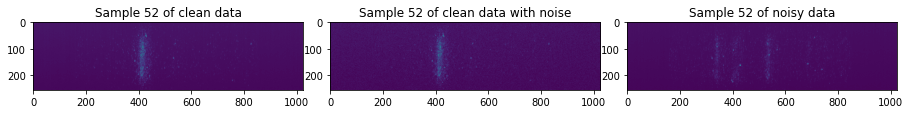

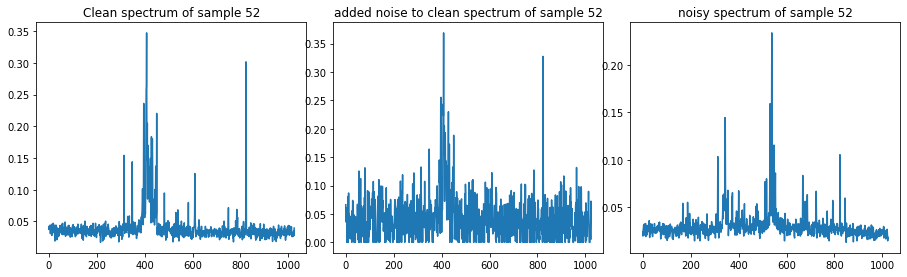

In [16]:
# By choosing random images , we start to show the data, before applying the DAE network
rand=np.random.randint(0,len(clean))
noise_factor=0.03
compare(clean,train_dataset,noise,noise_factor,rand)

# Training Loop

EPOCH 1 / 50
Partial Train loss is 0.1765679568052292
Partial Train loss is 0.153495654463768
Partial Train loss is 0.13915589451789856
Partial Train loss is 0.12008316814899445
Partial Train loss is 0.10748585313558578
Partial Train loss is 0.0954074040055275
Partial Train loss is 0.08129554986953735
Partial Train loss is 0.07408388704061508
Partial Train loss is 0.06427346915006638
Partial Train loss is 0.053935837000608444
Partial Train loss is 0.04927254840731621
Partial Train loss is 0.042318858206272125
Partial Train loss is 0.03708970919251442
Partial Train loss is 0.03210492059588432
Partial Train loss is 0.028619324788451195
Partial Train loss is 0.025488508865237236
Partial Train loss is 0.022389134392142296
Partial Train loss is 0.02001122757792473
Partial Train loss is 0.017956219613552094
Partial Train loss is 0.014945966191589832
 
 Global  validation loss for this epoch  is 0.024559717625379562 

 EPOCH 1/50 	 train loss 0.068 	 val loss 0.025


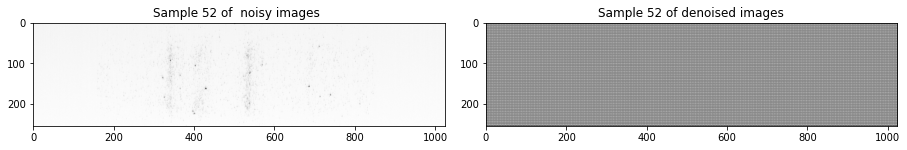

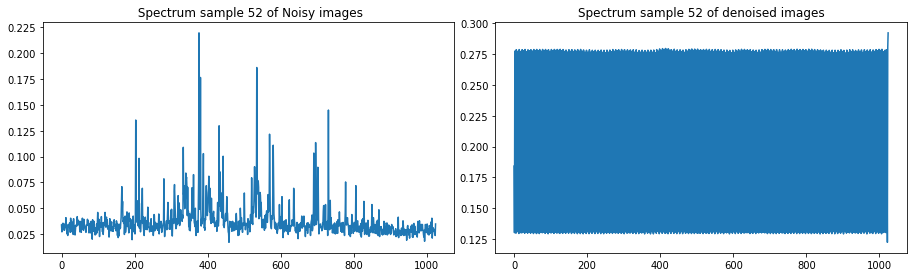

EPOCH 2 / 50
Partial Train loss is 0.013785633258521557
Partial Train loss is 0.01304048765450716
Partial Train loss is 0.01174168474972248


[W accumulate_grad.h:185] Warning: grad and param do not obey the gradient layout contract. This is not an error, but may impair performance.
grad.sizes() = [8, 1, 3, 3], strides() = [9, 9, 3, 1]
param.sizes() = [8, 1, 3, 3], strides() = [9, 1, 3, 1] (function operator())


Partial Train loss is 0.009948800317943096
Partial Train loss is 0.009099704213440418
Partial Train loss is 0.008248035795986652
Partial Train loss is 0.006965432316064835
Partial Train loss is 0.006734102964401245
Partial Train loss is 0.005931300111114979
Partial Train loss is 0.004938035737723112
Partial Train loss is 0.00481422757729888
Partial Train loss is 0.004248115699738264
Partial Train loss is 0.003965500742197037
Partial Train loss is 0.0035774658899754286
Partial Train loss is 0.003358434187248349
Partial Train loss is 0.0031025507487356663
Partial Train loss is 0.0029164229054003954
Partial Train loss is 0.0027278342749923468
Partial Train loss is 0.0026002060621976852
Partial Train loss is 0.0023425642866641283
 
 Global  validation loss for this epoch  is 0.004080737009644508 

 EPOCH 2/50 	 train loss 0.006 	 val loss 0.004


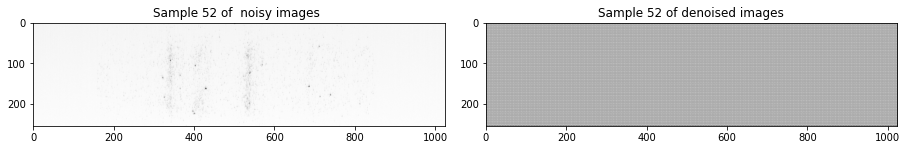

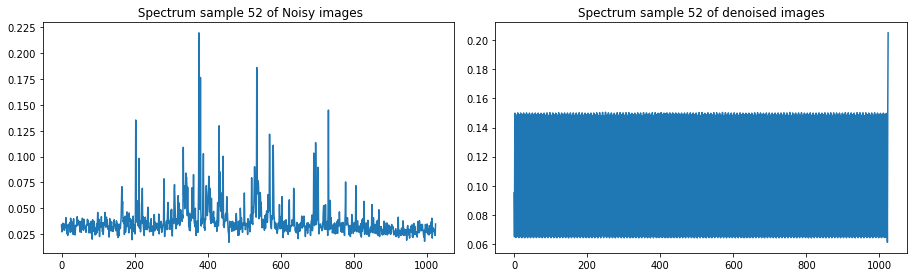

EPOCH 3 / 50
Partial Train loss is 0.002186120254918933
Partial Train loss is 0.0021039170678704977
Partial Train loss is 0.0020006808917969465
Partial Train loss is 0.001858993317000568
Partial Train loss is 0.0018407361349090934
Partial Train loss is 0.0017498008674010634
Partial Train loss is 0.0016361773014068604
Partial Train loss is 0.0016273517394438386
Partial Train loss is 0.0015302574029192328
Partial Train loss is 0.0014277991140261292
Partial Train loss is 0.001380514819175005
Partial Train loss is 0.0013046785024926066
Partial Train loss is 0.001349901664070785
Partial Train loss is 0.0013018238823860884
Partial Train loss is 0.0012594418367370963
Partial Train loss is 0.001178679522126913
Partial Train loss is 0.0012271866435185075
Partial Train loss is 0.0011966726742684841
Partial Train loss is 0.0012043010210618377
Partial Train loss is 0.0012267803540453315
 
 Global  validation loss for this epoch  is 0.002148092957213521 

 EPOCH 3/50 	 train loss 0.002 	 val loss 0

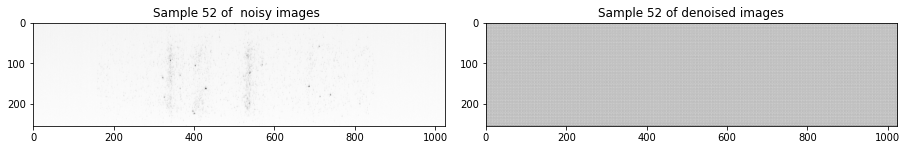

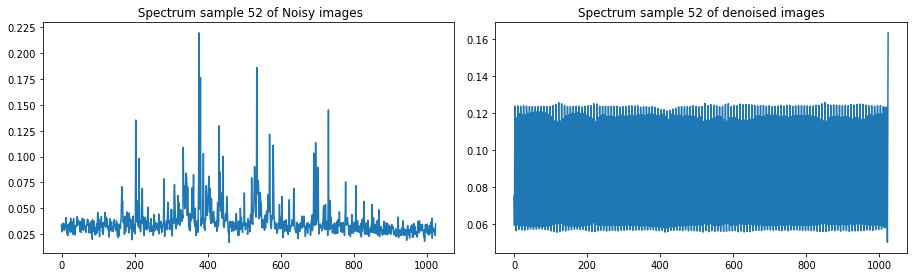

EPOCH 4 / 50
Partial Train loss is 0.0011230119271203876
Partial Train loss is 0.0011746047530323267
Partial Train loss is 0.0010174530325457454
Partial Train loss is 0.0010027358075603843
Partial Train loss is 0.0010105426190420985
Partial Train loss is 0.0009733954793773592
Partial Train loss is 0.0010062353685498238
Partial Train loss is 0.0009574571740813553
Partial Train loss is 0.0009411003557033837
Partial Train loss is 0.0009762646513991058
Partial Train loss is 0.0008776727481745183
Partial Train loss is 0.0008728415123187006
Partial Train loss is 0.0009435441461391747
Partial Train loss is 0.0009431286016479135
Partial Train loss is 0.0009208917617797852
Partial Train loss is 0.000856553204357624
Partial Train loss is 0.0009220314095728099
Partial Train loss is 0.0008477129158563912
Partial Train loss is 0.000836767430882901
Partial Train loss is 0.0009395849774591625
 
 Global  validation loss for this epoch  is 0.0016326733166351914 

 EPOCH 4/50 	 train loss 0.001 	 val lo

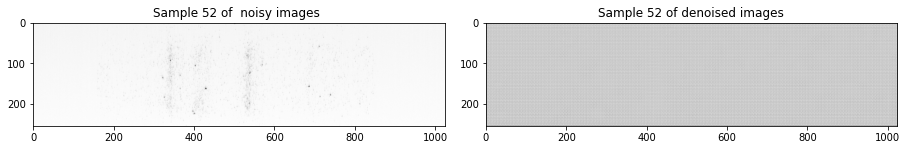

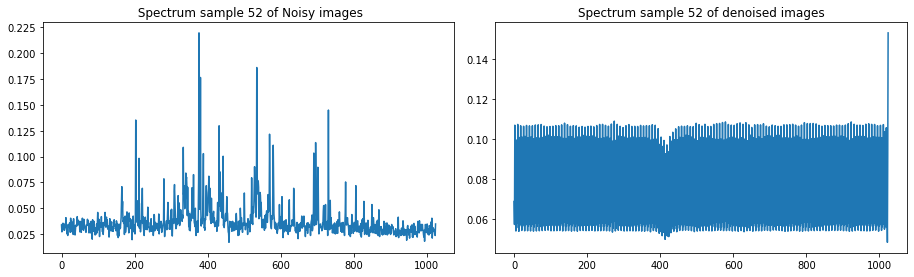

EPOCH 5 / 50
Partial Train loss is 0.0008414306794293225
Partial Train loss is 0.0009378194808959961
Partial Train loss is 0.0007543560932390392
Partial Train loss is 0.0007822566549293697
Partial Train loss is 0.0007845697109587491
Partial Train loss is 0.0007500226492993534
Partial Train loss is 0.0008055138750933111
Partial Train loss is 0.0007592253969050944
Partial Train loss is 0.0007658229442313313
Partial Train loss is 0.0008093867800198495
Partial Train loss is 0.0007561935344710946
Partial Train loss is 0.0008012029575183988
Partial Train loss is 0.0008291718550026417
Partial Train loss is 0.00081664725439623
Partial Train loss is 0.000782054674346
Partial Train loss is 0.0006853193044662476
Partial Train loss is 0.0007542616222053766
Partial Train loss is 0.0007029353291727602
Partial Train loss is 0.0006896172417327762
Partial Train loss is 0.0008105390006676316
 
 Global  validation loss for this epoch  is 0.0017430579755455256 

 EPOCH 5/50 	 train loss 0.001 	 val loss 0

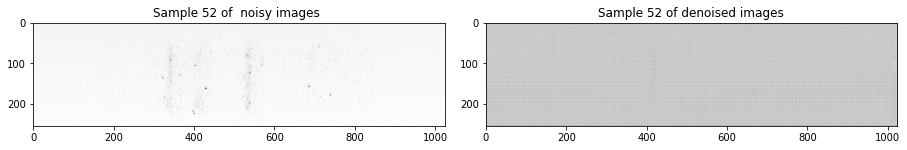

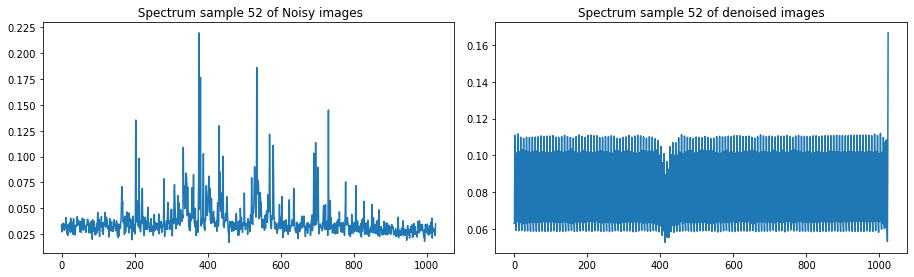

EPOCH 6 / 50
Partial Train loss is 0.0007116495980881155
Partial Train loss is 0.000812572252471
Partial Train loss is 0.0006457293056882918
Partial Train loss is 0.0006739508826285601
Partial Train loss is 0.0006785325822420418
Partial Train loss is 0.0006396716344170272
Partial Train loss is 0.0007043470977805555
Partial Train loss is 0.0006555550498887897
Partial Train loss is 0.0006870111683383584
Partial Train loss is 0.0007138645742088556
Partial Train loss is 0.0006657506455667317
Partial Train loss is 0.0006371666095219553
Partial Train loss is 0.0007432386046275496
Partial Train loss is 0.00070936483098194
Partial Train loss is 0.0006739929667674005
Partial Train loss is 0.0005967005854472518
Partial Train loss is 0.0006507209618575871
Partial Train loss is 0.0006057485588826239
Partial Train loss is 0.0005995842511765659
Partial Train loss is 0.0007241246639750898
 
 Global  validation loss for this epoch  is 0.002300278050825 

 EPOCH 6/50 	 train loss 0.001 	 val loss 0.002

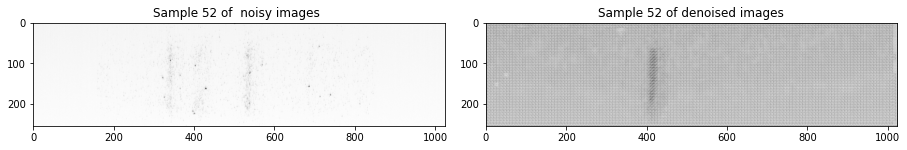

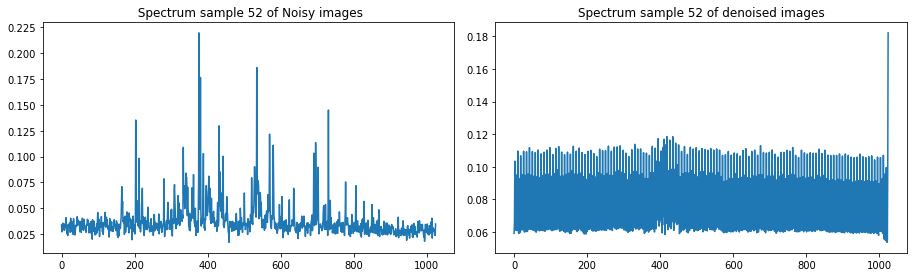

EPOCH 7 / 50
Partial Train loss is 0.0006202011718414724
Partial Train loss is 0.0007246585446409881
Partial Train loss is 0.0005733956932090223
Partial Train loss is 0.0005970032070763409
Partial Train loss is 0.0006014520185999572
Partial Train loss is 0.0005587085033766925
Partial Train loss is 0.0006152504938654602
Partial Train loss is 0.0005912917549721897
Partial Train loss is 0.000583463057409972
Partial Train loss is 0.0006641243235208094
Partial Train loss is 0.0005319693009369075
Partial Train loss is 0.0005353559972718358
Partial Train loss is 0.0006161610945127904
Partial Train loss is 0.0006122206686995924
Partial Train loss is 0.0005849981098435819
Partial Train loss is 0.000504027702845633
Partial Train loss is 0.0005718229222111404
Partial Train loss is 0.0005276973242871463
Partial Train loss is 0.0005260796169750392
Partial Train loss is 0.0006469517247751355
 
 Global  validation loss for this epoch  is 0.0015748777659609914 

 EPOCH 7/50 	 train loss 0.001 	 val lo

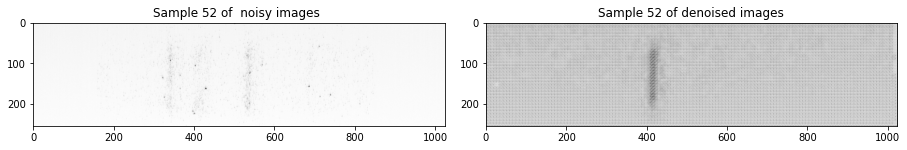

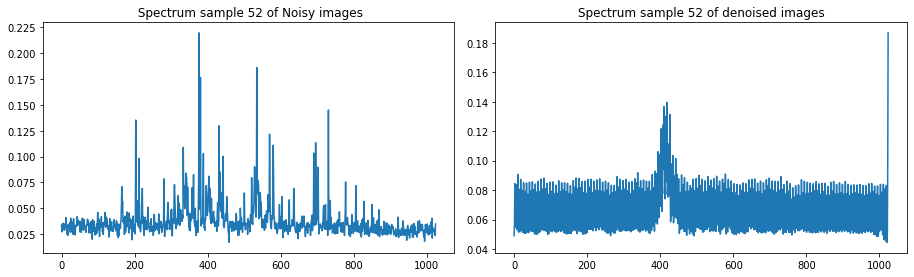

EPOCH 8 / 50
Partial Train loss is 0.0005444952403195202
Partial Train loss is 0.0006409575580619276
Partial Train loss is 0.0004914320888929069
Partial Train loss is 0.0005304883816279471
Partial Train loss is 0.0005263659986667335
Partial Train loss is 0.0004938437486998737
Partial Train loss is 0.0005607552593573928
Partial Train loss is 0.0005042773555032909
Partial Train loss is 0.0005016494542360306
Partial Train loss is 0.0005663034971803427
Partial Train loss is 0.00046001383452676237
Partial Train loss is 0.0004639997205231339
Partial Train loss is 0.0005404865951277316
Partial Train loss is 0.0005424484261311591
Partial Train loss is 0.0005165721522644162
Partial Train loss is 0.0004457615432329476
Partial Train loss is 0.00050673185614869
Partial Train loss is 0.00046567953540943563
Partial Train loss is 0.0004631502088159323
Partial Train loss is 0.0005779213388450444
 
 Global  validation loss for this epoch  is 0.0009814888471737504 

 EPOCH 8/50 	 train loss 0.001 	 val 

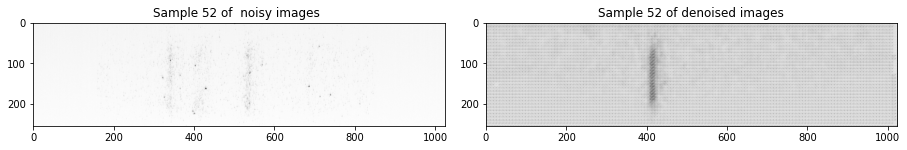

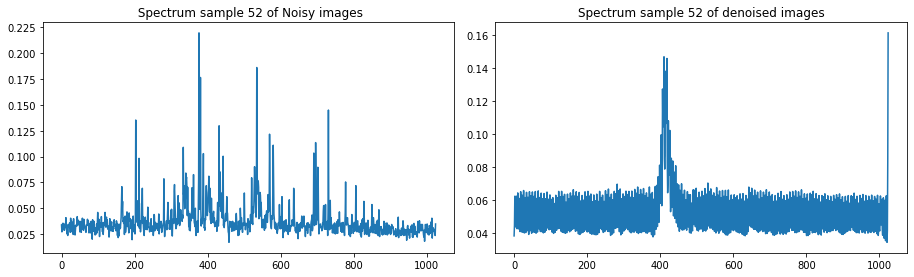

EPOCH 9 / 50
Partial Train loss is 0.0004932237206958234
Partial Train loss is 0.0005906265578232706
Partial Train loss is 0.00043681589886546135
Partial Train loss is 0.0004617970553226769
Partial Train loss is 0.0004665647284127772
Partial Train loss is 0.000434475572546944
Partial Train loss is 0.0004946216940879822
Partial Train loss is 0.0004539884102996439
Partial Train loss is 0.0004510803264565766
Partial Train loss is 0.0005228619556874037
Partial Train loss is 0.00041831834823824465
Partial Train loss is 0.0004152742330916226
Partial Train loss is 0.0004914934979751706
Partial Train loss is 0.000490890524815768
Partial Train loss is 0.0004606866277754307
Partial Train loss is 0.0003991254197899252
Partial Train loss is 0.0004535508342087269
Partial Train loss is 0.000418826297391206
Partial Train loss is 0.00041626469464972615
Partial Train loss is 0.0005196653655730188
 
 Global  validation loss for this epoch  is 0.0005697350134141743 

 EPOCH 9/50 	 train loss 0.000 	 val 

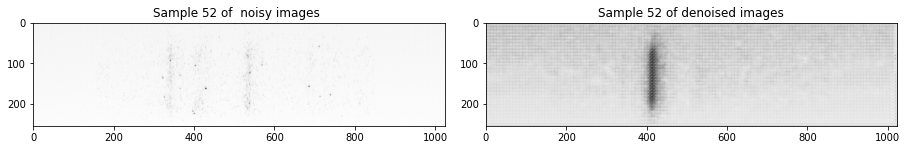

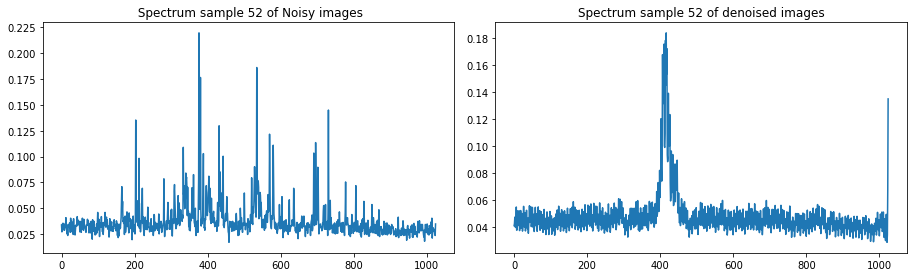

EPOCH 10 / 50
Partial Train loss is 0.0004452606663107872
Partial Train loss is 0.0005207823705859482
Partial Train loss is 0.0003989034448750317
Partial Train loss is 0.0004290970100555569
Partial Train loss is 0.0004303153255023062
Partial Train loss is 0.00040130308480001986
Partial Train loss is 0.00045914723887108266
Partial Train loss is 0.0004154795897193253
Partial Train loss is 0.0004043690860271454
Partial Train loss is 0.0004694522067438811
Partial Train loss is 0.00037896280991844833
Partial Train loss is 0.0003770370676647872
Partial Train loss is 0.00044952455209568143
Partial Train loss is 0.0004486338293645531
Partial Train loss is 0.0004232251667417586
Partial Train loss is 0.0003672133607324213
Partial Train loss is 0.000415526534197852
Partial Train loss is 0.0003838911361526698
Partial Train loss is 0.00037977061583660543
Partial Train loss is 0.00047877320321276784
 
 Global  validation loss for this epoch  is 0.0006407212931662798 

 EPOCH 10/50 	 train loss 0.000

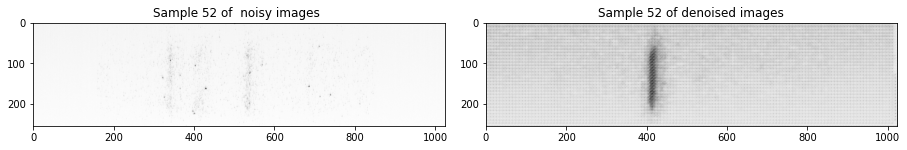

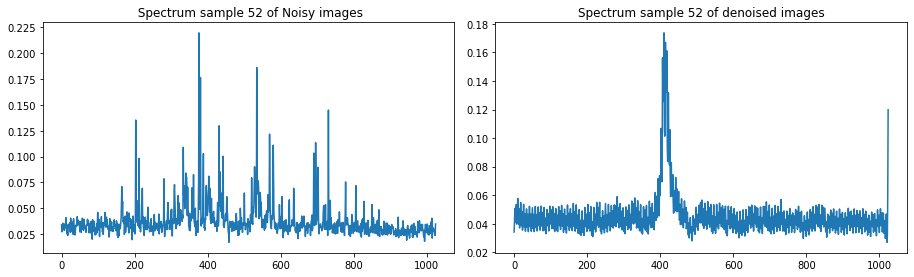

EPOCH 11 / 50
Partial Train loss is 0.0004087769484613091
Partial Train loss is 0.00047816522419452667
Partial Train loss is 0.0003672804159577936
Partial Train loss is 0.0004008834366686642
Partial Train loss is 0.00040302914567291737
Partial Train loss is 0.0003683111281134188
Partial Train loss is 0.00041860720375552773
Partial Train loss is 0.0003864942991640419
Partial Train loss is 0.0003786147281061858
Partial Train loss is 0.0004401842306833714
Partial Train loss is 0.00035202698200009763
Partial Train loss is 0.00034521505585871637
Partial Train loss is 0.0004112848546355963
Partial Train loss is 0.000411278655519709
Partial Train loss is 0.0003837607800960541
Partial Train loss is 0.0003352769708726555
Partial Train loss is 0.0003800081030931324
Partial Train loss is 0.00035642620059661567
Partial Train loss is 0.0003611427964642644
Partial Train loss is 0.00044541858369484544
 
 Global  validation loss for this epoch  is 0.0003743424022104591 

 EPOCH 11/50 	 train loss 0.00

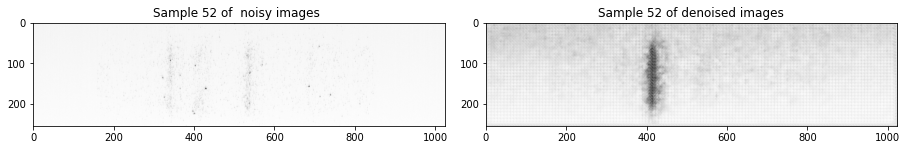

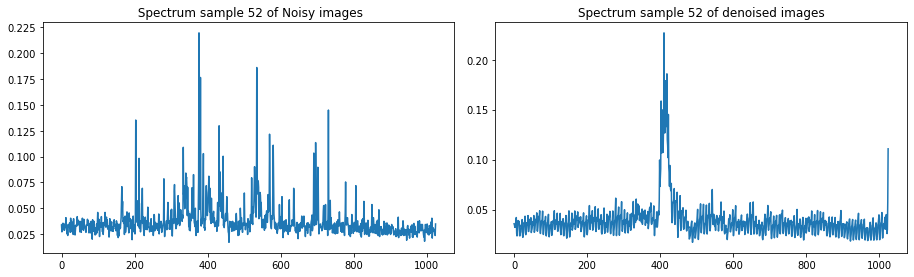

EPOCH 12 / 50
Partial Train loss is 0.0003830734931398183
Partial Train loss is 0.00045087069156579673
Partial Train loss is 0.00034086190862581134
Partial Train loss is 0.00036447547608986497
Partial Train loss is 0.0003803527797572315
Partial Train loss is 0.0003440352447796613
Partial Train loss is 0.0003934003470931202
Partial Train loss is 0.0003677640052046627
Partial Train loss is 0.0003502033359836787
Partial Train loss is 0.0004129660374019295
Partial Train loss is 0.00032521941466256976
Partial Train loss is 0.0003229496069252491
Partial Train loss is 0.000384101876989007
Partial Train loss is 0.00038304852205328643
Partial Train loss is 0.00035874685272574425
Partial Train loss is 0.0003158740873914212
Partial Train loss is 0.00035551009932532907
Partial Train loss is 0.00033127370988950133
Partial Train loss is 0.00033195261494256556
Partial Train loss is 0.00041349977254867554
 
 Global  validation loss for this epoch  is 0.00035675763501785696 

 EPOCH 12/50 	 train loss 

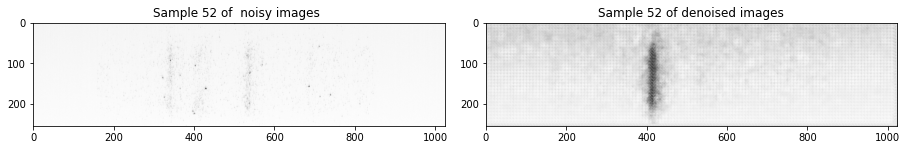

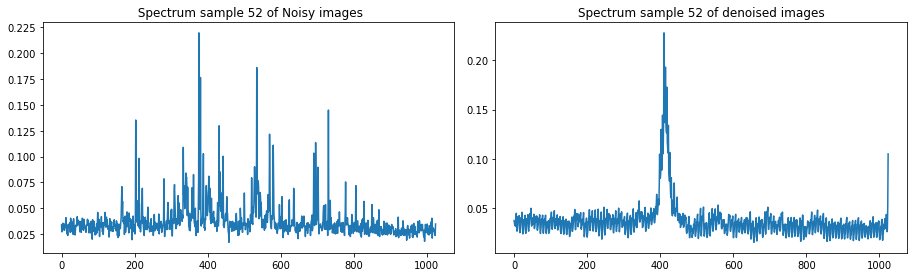

EPOCH 13 / 50
Partial Train loss is 0.00035933079198002815
Partial Train loss is 0.0004222467541694641
Partial Train loss is 0.00032569756149314344
Partial Train loss is 0.0003410369099583477
Partial Train loss is 0.00035282765747979283
Partial Train loss is 0.00032215341343544424
Partial Train loss is 0.00037063556374050677
Partial Train loss is 0.00034125777892768383
Partial Train loss is 0.00033653233549557626
Partial Train loss is 0.00038913392927497625
Partial Train loss is 0.00030999333830550313
Partial Train loss is 0.0003017955459654331
Partial Train loss is 0.0003612831933423877
Partial Train loss is 0.0003592983412090689
Partial Train loss is 0.00033537554554641247
Partial Train loss is 0.00029912093305028975
Partial Train loss is 0.0003332018095534295
Partial Train loss is 0.0003140365006402135
Partial Train loss is 0.000317699508741498
Partial Train loss is 0.00039411531179212034
 
 Global  validation loss for this epoch  is 0.00031376865808852017 

 EPOCH 13/50 	 train los

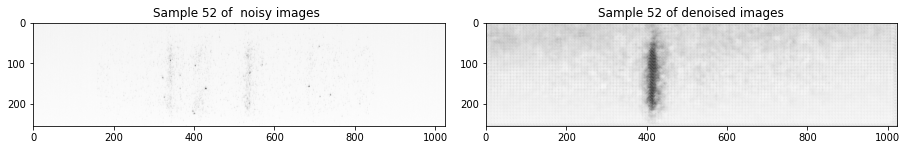

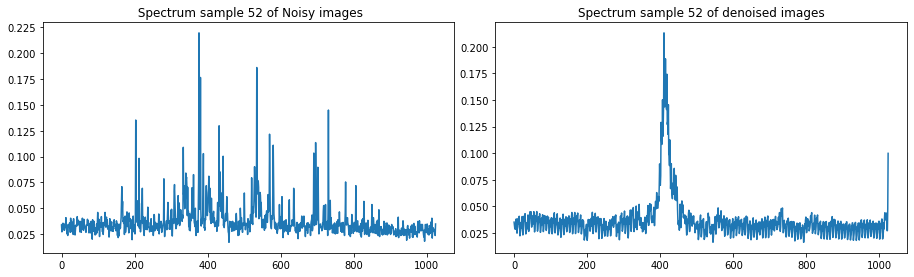

EPOCH 14 / 50
Partial Train loss is 0.0003397240361664444
Partial Train loss is 0.0003977491578552872
Partial Train loss is 0.00030881675775162876
Partial Train loss is 0.0003267157881055027
Partial Train loss is 0.00034070381661877036
Partial Train loss is 0.00030889344634488225
Partial Train loss is 0.0003567578678485006
Partial Train loss is 0.0003232134913560003
Partial Train loss is 0.0003161589556839317
Partial Train loss is 0.00036901491694152355
Partial Train loss is 0.00029281069873832166
Partial Train loss is 0.0002853006008081138
Partial Train loss is 0.00033729334245435894
Partial Train loss is 0.00033673187135718763
Partial Train loss is 0.00031729499460197985
Partial Train loss is 0.00028159847715869546
Partial Train loss is 0.000318815466016531
Partial Train loss is 0.0002917909878306091
Partial Train loss is 0.00029634017846547067
Partial Train loss is 0.000363111961632967
 
 Global  validation loss for this epoch  is 0.0005040898686274886 

 EPOCH 14/50 	 train loss 0.

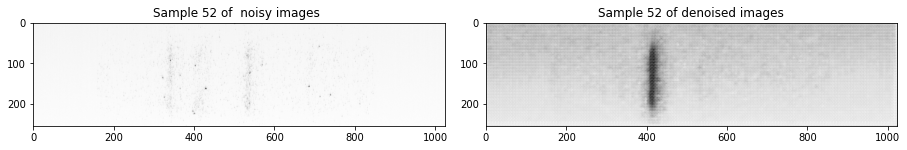

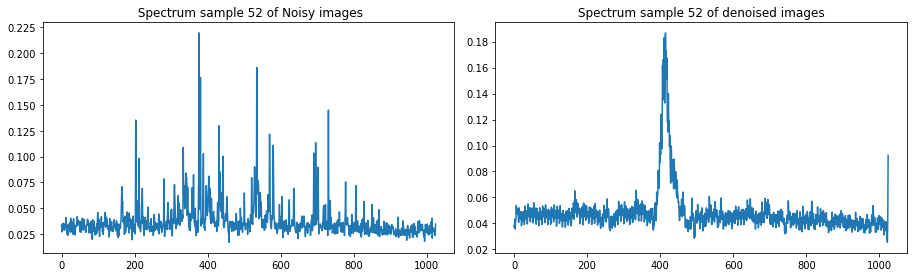

EPOCH 15 / 50
Partial Train loss is 0.0003227858687750995
Partial Train loss is 0.00038177004898898304
Partial Train loss is 0.000290780357317999
Partial Train loss is 0.0003080492024309933
Partial Train loss is 0.0003213721502106637
Partial Train loss is 0.0002889731840696186
Partial Train loss is 0.0003394333180040121
Partial Train loss is 0.00030377518851310015
Partial Train loss is 0.00030115319532342255
Partial Train loss is 0.0003564595535863191
Partial Train loss is 0.00028196413768455386
Partial Train loss is 0.00027005214360542595
Partial Train loss is 0.0003219282370992005
Partial Train loss is 0.0003227591223549098
Partial Train loss is 0.0002973460068460554
Partial Train loss is 0.0002662448096089065
Partial Train loss is 0.00030356537899933755
Partial Train loss is 0.0002797336783260107
Partial Train loss is 0.0002821509842760861
Partial Train loss is 0.00034961476922035217
 
 Global  validation loss for this epoch  is 0.0002784346870612353 

 EPOCH 15/50 	 train loss 0.00

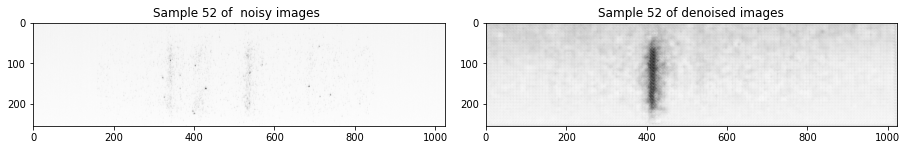

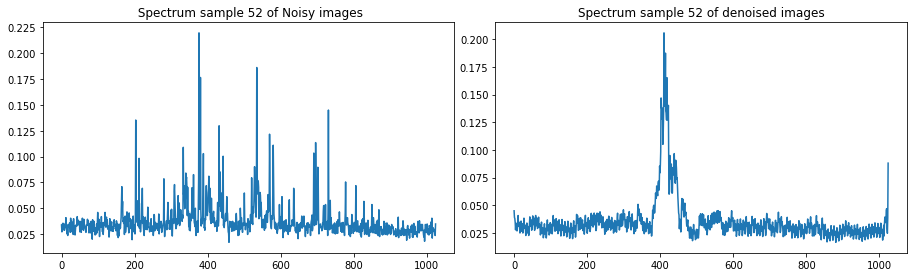

EPOCH 16 / 50
Partial Train loss is 0.0003085595089942217
Partial Train loss is 0.00035831143031828105
Partial Train loss is 0.0002802001254167408
Partial Train loss is 0.0002931762137450278
Partial Train loss is 0.0003120519395451993
Partial Train loss is 0.00027542837779037654
Partial Train loss is 0.0003287984000053257
Partial Train loss is 0.00030008607427589595
Partial Train loss is 0.00028855589334852993
Partial Train loss is 0.00034508557291701436
Partial Train loss is 0.0002704263315536082
Partial Train loss is 0.0002587738854344934
Partial Train loss is 0.0003103296912740916
Partial Train loss is 0.00031050629331730306
Partial Train loss is 0.00028683195705525577
Partial Train loss is 0.0002563573361840099
Partial Train loss is 0.0002911501214839518
Partial Train loss is 0.00027017315733246505
Partial Train loss is 0.0002715192676987499
Partial Train loss is 0.0003326473233755678
 
 Global  validation loss for this epoch  is 0.0005415785126388073 

 EPOCH 16/50 	 train loss 0.

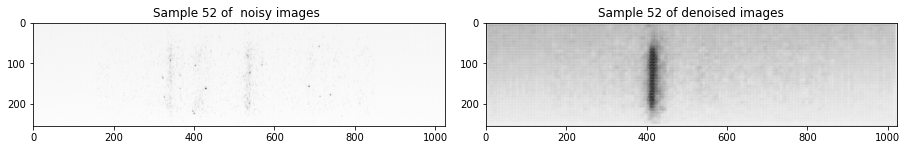

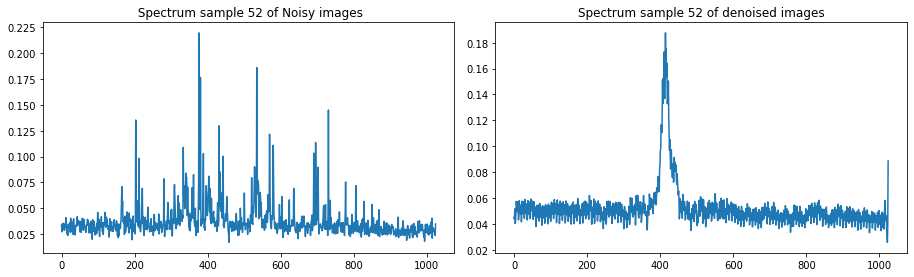

EPOCH 17 / 50
Partial Train loss is 0.00030100494041107595
Partial Train loss is 0.0003474393452052027
Partial Train loss is 0.0002744820376392454
Partial Train loss is 0.00028490732074715197
Partial Train loss is 0.0002970383211504668
Partial Train loss is 0.00026969931786879897
Partial Train loss is 0.0003163015644531697
Partial Train loss is 0.00028584818937815726
Partial Train loss is 0.0002820199297275394
Partial Train loss is 0.0003367849567439407
Partial Train loss is 0.00027195122675038874
Partial Train loss is 0.0002527471224311739
Partial Train loss is 0.0003082716721110046
Partial Train loss is 0.0003075982676818967
Partial Train loss is 0.00027991816750727594
Partial Train loss is 0.00025222692056559026
Partial Train loss is 0.0002828686556313187
Partial Train loss is 0.00026486744172871113
Partial Train loss is 0.000265249953372404
Partial Train loss is 0.00033188340603373945
 
 Global  validation loss for this epoch  is 0.0005464034620672464 

 EPOCH 17/50 	 train loss 0.

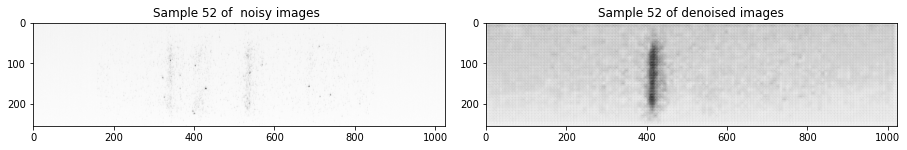

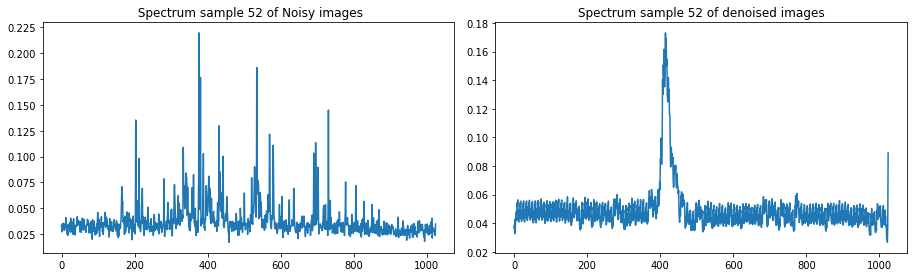

EPOCH 18 / 50
Partial Train loss is 0.0002958843542728573
Partial Train loss is 0.000338543119141832
Partial Train loss is 0.0002684516948647797
Partial Train loss is 0.0002699553151614964
Partial Train loss is 0.0002866601280402392
Partial Train loss is 0.00026102695846930146
Partial Train loss is 0.0003089548263233155
Partial Train loss is 0.00027652946300804615
Partial Train loss is 0.0002725305675994605
Partial Train loss is 0.00033057291875593364
Partial Train loss is 0.0002677976153790951
Partial Train loss is 0.0002567415067460388
Partial Train loss is 0.0003071784449275583
Partial Train loss is 0.00029963869019411504
Partial Train loss is 0.00027788011357188225
Partial Train loss is 0.00024749862495809793
Partial Train loss is 0.00027814204804599285
Partial Train loss is 0.00025969708804041147
Partial Train loss is 0.0002597003767732531
Partial Train loss is 0.0003218261699657887
 
 Global  validation loss for this epoch  is 0.0004521198570728302 

 EPOCH 18/50 	 train loss 0.0

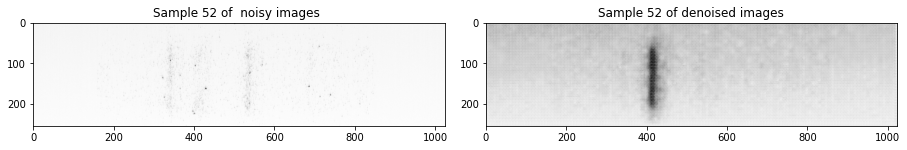

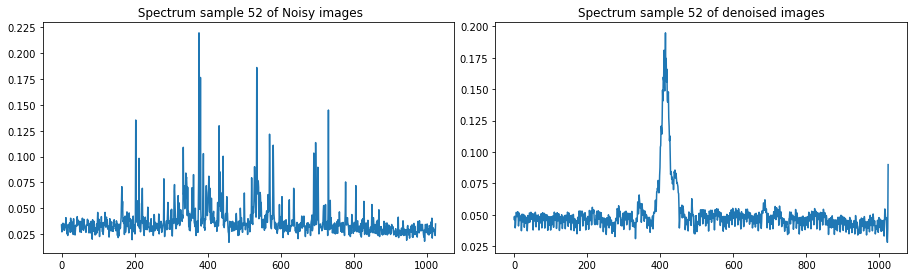

EPOCH 19 / 50
Partial Train loss is 0.0002876509679481387
Partial Train loss is 0.00033181949402205646
Partial Train loss is 0.00026849625282920897
Partial Train loss is 0.0002772531006485224
Partial Train loss is 0.00028836040291935205
Partial Train loss is 0.00026114299544133246
Partial Train loss is 0.00029934808844700456
Partial Train loss is 0.0002870405151043087
Partial Train loss is 0.0002736411988735199
Partial Train loss is 0.0003265568520873785
Partial Train loss is 0.0002633102412801236
Partial Train loss is 0.0002481869887560606
Partial Train loss is 0.00029888327117078006
Partial Train loss is 0.0002974031667690724
Partial Train loss is 0.0002755380410235375
Partial Train loss is 0.00024491717340424657
Partial Train loss is 0.00028052969719283283
Partial Train loss is 0.0002550093049649149
Partial Train loss is 0.00025875013670884073
Partial Train loss is 0.00031151436269283295
 
 Global  validation loss for this epoch  is 0.0004739640571642667 

 EPOCH 19/50 	 train loss 

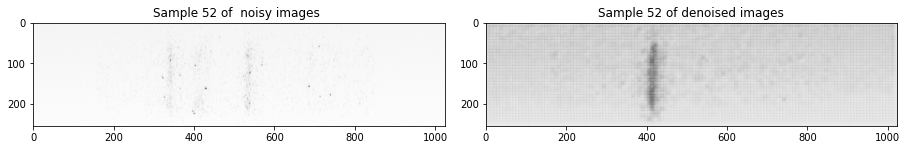

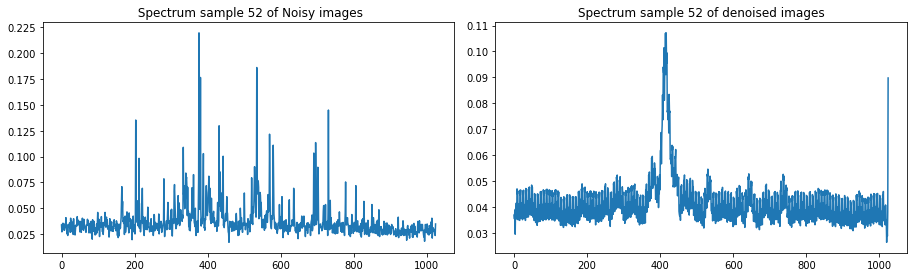

EPOCH 20 / 50
Partial Train loss is 0.0002846255374606699
Partial Train loss is 0.00032700831070542336
Partial Train loss is 0.0002610882220324129
Partial Train loss is 0.000274598685791716
Partial Train loss is 0.00028426750213839114
Partial Train loss is 0.00025745268794707954
Partial Train loss is 0.0002975865500047803
Partial Train loss is 0.00026905268896371126
Partial Train loss is 0.00026529902243055403
Partial Train loss is 0.0003193526645191014
Partial Train loss is 0.0002644220076035708
Partial Train loss is 0.0002454631612636149
Partial Train loss is 0.00029969352181069553
Partial Train loss is 0.0002954376977868378
Partial Train loss is 0.0002703748759813607
Partial Train loss is 0.00024199792824219912
Partial Train loss is 0.0002743852382991463
Partial Train loss is 0.00025298958644270897
Partial Train loss is 0.000252908852417022
Partial Train loss is 0.00030840220279060304
 
 Global  validation loss for this epoch  is 0.00045885195140726864 

 EPOCH 20/50 	 train loss 0.

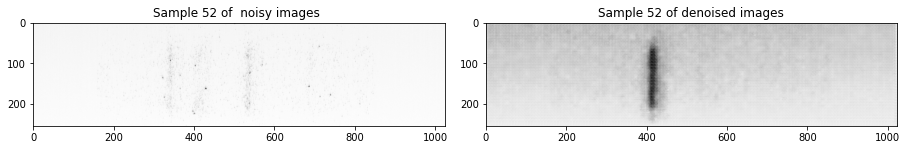

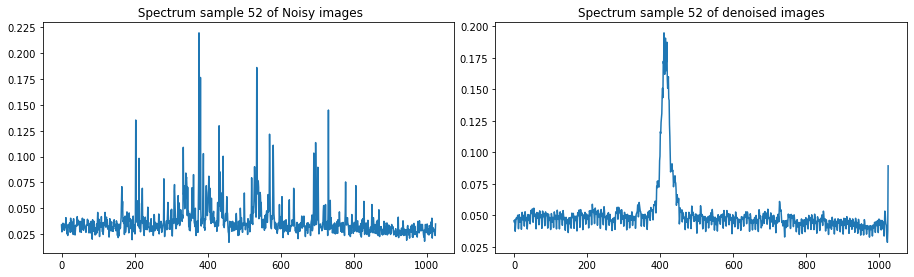

EPOCH 21 / 50
Partial Train loss is 0.0002800545480567962
Partial Train loss is 0.00032588696922175586
Partial Train loss is 0.00026189140044152737
Partial Train loss is 0.0002704971411731094
Partial Train loss is 0.000278797117061913
Partial Train loss is 0.0002544557210057974
Partial Train loss is 0.00029252973035909235
Partial Train loss is 0.00026672196690924466
Partial Train loss is 0.0002636464196257293
Partial Train loss is 0.00031947458046488464
Partial Train loss is 0.00026546246954239905
Partial Train loss is 0.00024452563957311213
Partial Train loss is 0.00030062906444072723
Partial Train loss is 0.0002974954550154507
Partial Train loss is 0.0002671247348189354
Partial Train loss is 0.00024201870837714523
Partial Train loss is 0.0002691957342904061
Partial Train loss is 0.0002523427829146385
Partial Train loss is 0.0002501845301594585
Partial Train loss is 0.00030982709722593427
 
 Global  validation loss for this epoch  is 0.0006111015100032091 

 EPOCH 21/50 	 train loss 0

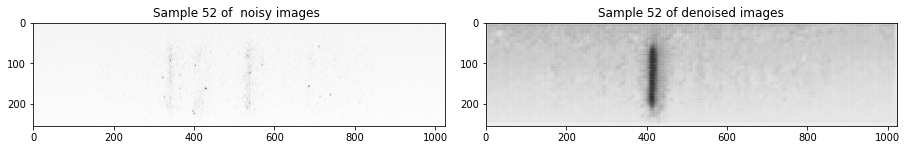

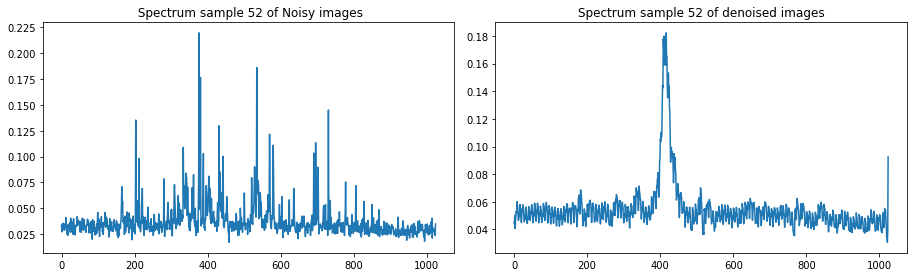

EPOCH 22 / 50
Partial Train loss is 0.0002792048908304423
Partial Train loss is 0.0003271125315222889
Partial Train loss is 0.00026159713161177933
Partial Train loss is 0.0002777671907097101
Partial Train loss is 0.00028282232233323157
Partial Train loss is 0.00025354643003083766
Partial Train loss is 0.0002894224307965487
Partial Train loss is 0.00027046850300394
Partial Train loss is 0.0002623006876092404
Partial Train loss is 0.00031876933644525707
Partial Train loss is 0.00024909916101023555
Partial Train loss is 0.0002395466435700655
Partial Train loss is 0.0002855441998690367
Partial Train loss is 0.00028823339380323887
Partial Train loss is 0.0002644512278493494
Partial Train loss is 0.0002353251475142315
Partial Train loss is 0.00026718416484072804
Partial Train loss is 0.0002464519930072129
Partial Train loss is 0.0002469896571710706
Partial Train loss is 0.00030401625554077327
 
 Global  validation loss for this epoch  is 0.00046564184594899416 

 EPOCH 22/50 	 train loss 0.0

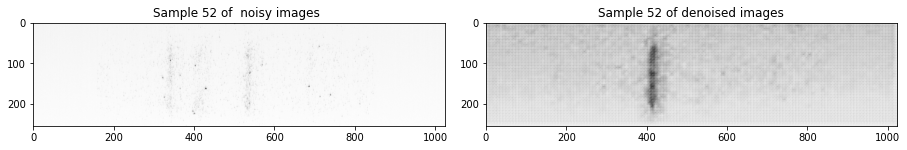

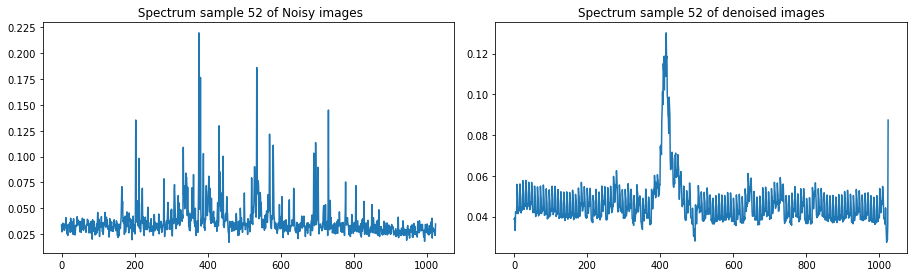

EPOCH 23 / 50
Partial Train loss is 0.00027497834526002407
Partial Train loss is 0.0003235923941247165
Partial Train loss is 0.0002587614580988884
Partial Train loss is 0.0002777434419840574
Partial Train loss is 0.0002810186706483364
Partial Train loss is 0.00025807807105593383
Partial Train loss is 0.0002914012875407934
Partial Train loss is 0.0002683863276615739
Partial Train loss is 0.00026371749117970467
Partial Train loss is 0.00031919428147375584
Partial Train loss is 0.0002520805865060538
Partial Train loss is 0.00023946996952872723
Partial Train loss is 0.0002876320213545114
Partial Train loss is 0.00028860452584922314
Partial Train loss is 0.0002634478732943535
Partial Train loss is 0.00023570354096591473
Partial Train loss is 0.000268409465206787
Partial Train loss is 0.0002459805109538138
Partial Train loss is 0.00024585460778325796
Partial Train loss is 0.00030249994597397745
 
 Global  validation loss for this epoch  is 0.00030745944241061807 

 EPOCH 23/50 	 train loss 0

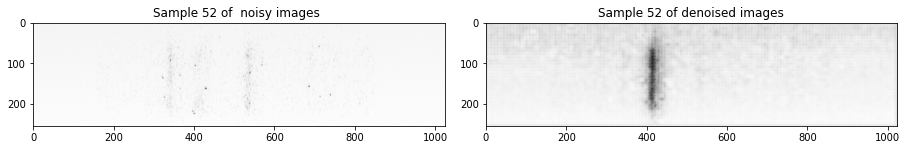

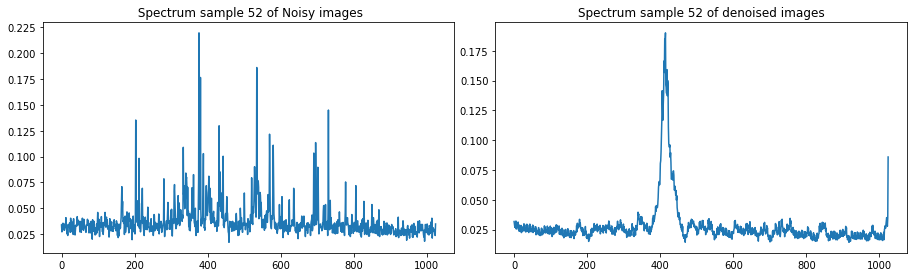

EPOCH 24 / 50
Partial Train loss is 0.0002740759518928826
Partial Train loss is 0.00031788856722414494
Partial Train loss is 0.00025800825096666813
Partial Train loss is 0.0002762052172329277
Partial Train loss is 0.0002792860905174166
Partial Train loss is 0.00025322611327283084
Partial Train loss is 0.0002881607797462493
Partial Train loss is 0.0002686031220946461
Partial Train loss is 0.00026089115999639034
Partial Train loss is 0.0003225041728001088
Partial Train loss is 0.0002464055723976344
Partial Train loss is 0.0002383924147579819
Partial Train loss is 0.000281941844150424
Partial Train loss is 0.00028673591441474855
Partial Train loss is 0.0002569612115621567
Partial Train loss is 0.00023477435752283782
Partial Train loss is 0.0002629840455483645
Partial Train loss is 0.0002451219188515097
Partial Train loss is 0.0002429789019515738
Partial Train loss is 0.00030032938229851425
 
 Global  validation loss for this epoch  is 0.0005544069572351873 

 EPOCH 24/50 	 train loss 0.00

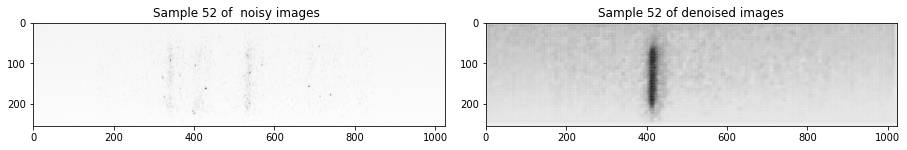

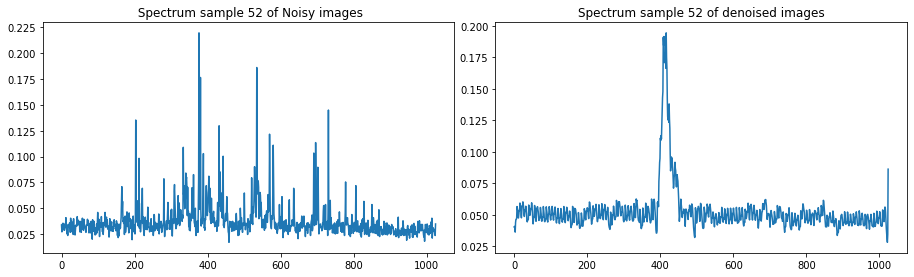

EPOCH 25 / 50
Partial Train loss is 0.00027177343145012856
Partial Train loss is 0.00031814214889891446
Partial Train loss is 0.0002536089741624892
Partial Train loss is 0.0002729522529989481
Partial Train loss is 0.00027508256607688963
Partial Train loss is 0.00025245104916393757
Partial Train loss is 0.000287200091406703
Partial Train loss is 0.0002604670007713139
Partial Train loss is 0.0002602097229100764
Partial Train loss is 0.00031855120323598385
Partial Train loss is 0.00024982113973237574
Partial Train loss is 0.00023680691083427519
Partial Train loss is 0.00028591995942406356
Partial Train loss is 0.0002875605132430792
Partial Train loss is 0.00025748845655471087
Partial Train loss is 0.00023334466095548123
Partial Train loss is 0.00026005256222561
Partial Train loss is 0.00024225884408224374
Partial Train loss is 0.00024168069649022073
Partial Train loss is 0.0002991381916217506
 
 Global  validation loss for this epoch  is 0.00026092820917256176 

 EPOCH 25/50 	 train loss 

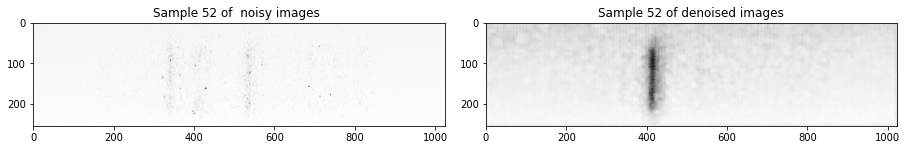

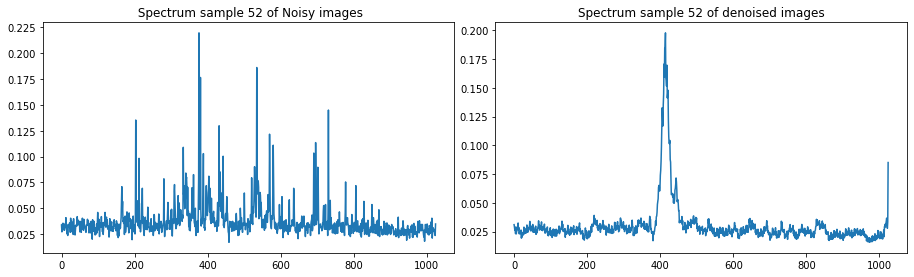

EPOCH 26 / 50
Partial Train loss is 0.00027246176614426076
Partial Train loss is 0.00031268244492821395
Partial Train loss is 0.0002552511577960104
Partial Train loss is 0.0002668195520527661
Partial Train loss is 0.0002752715954557061
Partial Train loss is 0.00024917369592003524
Partial Train loss is 0.0002855367201846093
Partial Train loss is 0.00026306978543289006
Partial Train loss is 0.00025822603492997587
Partial Train loss is 0.0003163577348459512
Partial Train loss is 0.0002531897334847599
Partial Train loss is 0.00023455200425814837
Partial Train loss is 0.0002850955934263766
Partial Train loss is 0.0002886902366299182
Partial Train loss is 0.0002556039544288069
Partial Train loss is 0.00023419850913342088
Partial Train loss is 0.0002591969387140125
Partial Train loss is 0.00024368835147470236
Partial Train loss is 0.00024141273752320558
Partial Train loss is 0.0003063846961595118
 
 Global  validation loss for this epoch  is 0.00027255670283921063 

 EPOCH 26/50 	 train loss 

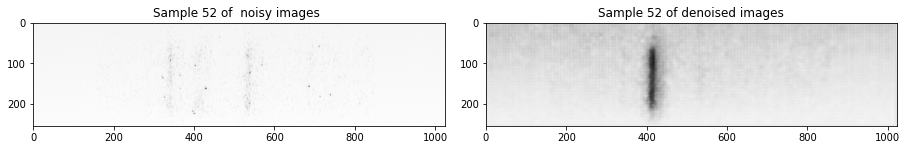

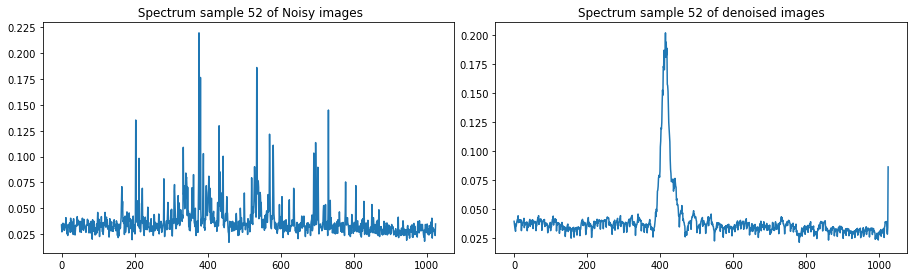

EPOCH 27 / 50
Partial Train loss is 0.00027280524955131114
Partial Train loss is 0.0003164488880429417
Partial Train loss is 0.0002492276835255325
Partial Train loss is 0.00026293049450032413
Partial Train loss is 0.0002696544979698956
Partial Train loss is 0.0002476819499861449
Partial Train loss is 0.0002879207895603031
Partial Train loss is 0.0002541533613111824
Partial Train loss is 0.0002545530442148447
Partial Train loss is 0.0003064170014113188
Partial Train loss is 0.00026341501506976783
Partial Train loss is 0.00024162376939784735
Partial Train loss is 0.00030000112019479275
Partial Train loss is 0.0002938220277428627
Partial Train loss is 0.0002619456499814987
Partial Train loss is 0.00023699919984210283
Partial Train loss is 0.00026895059272646904
Partial Train loss is 0.0002463671553414315
Partial Train loss is 0.00024198069877456874
Partial Train loss is 0.00030005467124283314
 
 Global  validation loss for this epoch  is 0.0002585836045909673 

 EPOCH 27/50 	 train loss 0

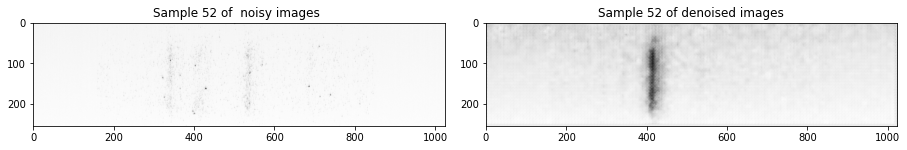

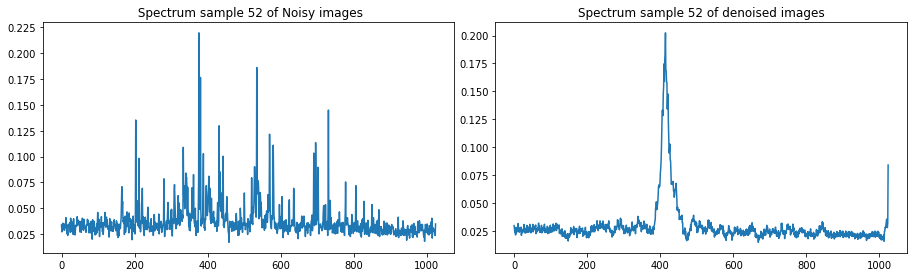

EPOCH 28 / 50
Partial Train loss is 0.00027259052149020135
Partial Train loss is 0.00031357910484075546
Partial Train loss is 0.00025882801855914295
Partial Train loss is 0.00026404010714031756
Partial Train loss is 0.0002768572303466499
Partial Train loss is 0.0002459513198118657
Partial Train loss is 0.0002863980771508068
Partial Train loss is 0.0002647746878210455
Partial Train loss is 0.00025557228946127
Partial Train loss is 0.00031998715712688863
Partial Train loss is 0.00023703428450971842
Partial Train loss is 0.00023566499294247478
Partial Train loss is 0.00027124659391120076
Partial Train loss is 0.0002807029231917113
Partial Train loss is 0.00025067824753932655
Partial Train loss is 0.00023177881666924804
Partial Train loss is 0.00025459020980633795
Partial Train loss is 0.00023973970382940024
Partial Train loss is 0.00023890472948551178
Partial Train loss is 0.0003002120938617736
 
 Global  validation loss for this epoch  is 0.0002916450903285295 

 EPOCH 28/50 	 train loss

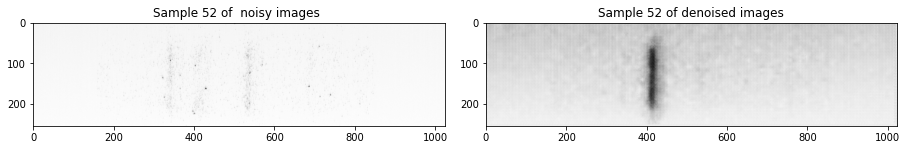

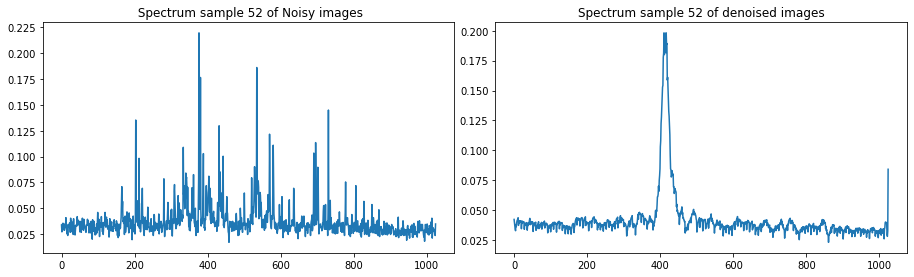

EPOCH 29 / 50
Partial Train loss is 0.0002711069246288389
Partial Train loss is 0.0003182784712407738
Partial Train loss is 0.0002497089153621346
Partial Train loss is 0.00026457561762072146
Partial Train loss is 0.0002721510536503047
Partial Train loss is 0.0002478042442817241
Partial Train loss is 0.00029084875131957233
Partial Train loss is 0.00025743318838067353
Partial Train loss is 0.0002574571408331394
Partial Train loss is 0.00030615352443419397
Partial Train loss is 0.00025409480440430343
Partial Train loss is 0.00023382683866657317
Partial Train loss is 0.00028298082179389894
Partial Train loss is 0.00027925873291678727
Partial Train loss is 0.0002864984271582216
Partial Train loss is 0.0002342162188142538
Partial Train loss is 0.00027778054936788976
Partial Train loss is 0.00024941173614934087
Partial Train loss is 0.0002499916299711913
Partial Train loss is 0.0003159519692417234
 
 Global  validation loss for this epoch  is 0.00028688457678072155 

 EPOCH 29/50 	 train loss

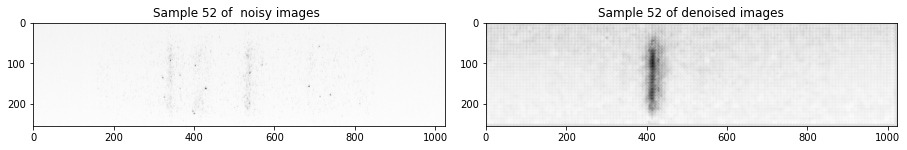

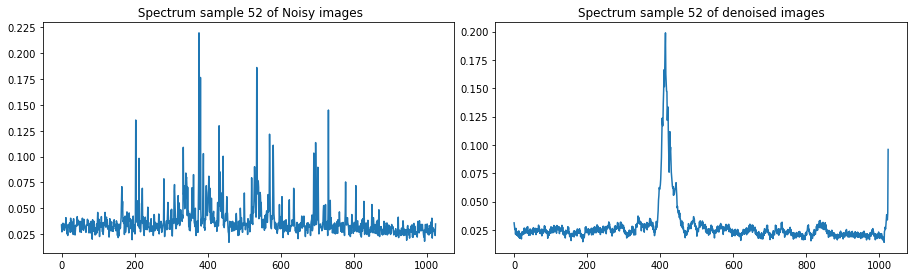

EPOCH 30 / 50
Partial Train loss is 0.0002761319337878376
Partial Train loss is 0.00031929361284710467
Partial Train loss is 0.000263068825006485
Partial Train loss is 0.0002733608998823911
Partial Train loss is 0.0002782247611321509
Partial Train loss is 0.0002496152592357248
Partial Train loss is 0.00028626638231799006
Partial Train loss is 0.00026563118444755673
Partial Train loss is 0.0002625547058414668
Partial Train loss is 0.0003150604316033423
Partial Train loss is 0.00024620024487376213
Partial Train loss is 0.00023519316164311022
Partial Train loss is 0.00029307021759450436
Partial Train loss is 0.000278633349807933
Partial Train loss is 0.0002719913609325886
Partial Train loss is 0.00022941739007364959
Partial Train loss is 0.0002607186324894428
Partial Train loss is 0.00024111122183967382
Partial Train loss is 0.0002419215888949111
Partial Train loss is 0.00029970472678542137
 
 Global  validation loss for this epoch  is 0.00047143525443971157 

 EPOCH 30/50 	 train loss 0.

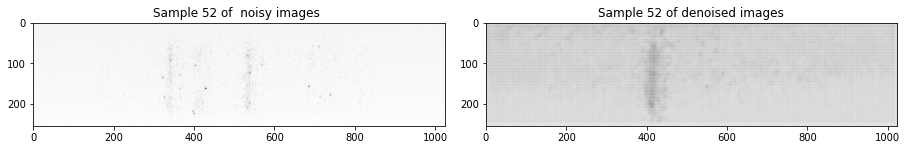

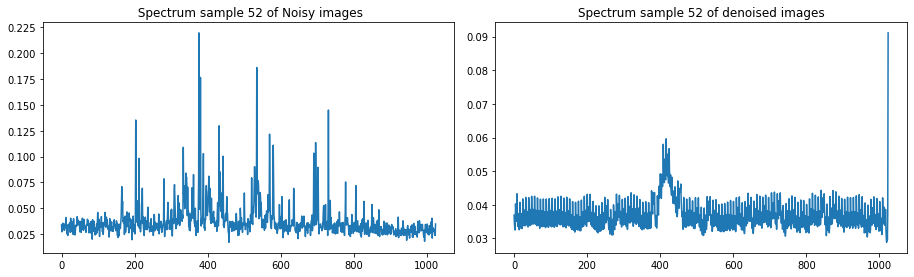

EPOCH 31 / 50
Partial Train loss is 0.00027378436061553657
Partial Train loss is 0.0003146651724819094
Partial Train loss is 0.00025710268528200686
Partial Train loss is 0.00027137683355249465
Partial Train loss is 0.00027769614825956523
Partial Train loss is 0.0002417225914541632
Partial Train loss is 0.00028407599893398583
Partial Train loss is 0.0002649080124683678
Partial Train loss is 0.00025639202794991434
Partial Train loss is 0.00032060942612588406
Partial Train loss is 0.0002362008672207594
Partial Train loss is 0.00023346487432718277
Partial Train loss is 0.0002734882873483002
Partial Train loss is 0.00027674235752783716
Partial Train loss is 0.0002551928337197751
Partial Train loss is 0.00022960091882850975
Partial Train loss is 0.0002593429817352444
Partial Train loss is 0.0002405313862254843
Partial Train loss is 0.00023687568318564445
Partial Train loss is 0.0002997124975081533
 
 Global  validation loss for this epoch  is 0.0002490888291504234 

 EPOCH 31/50 	 train loss

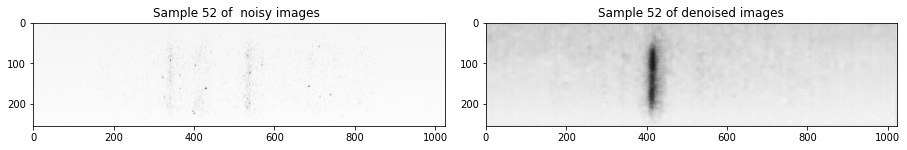

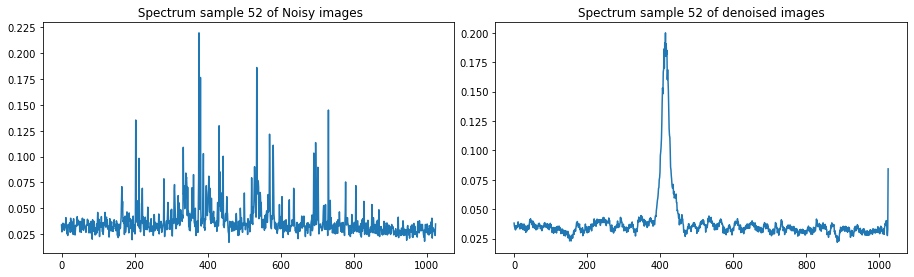

EPOCH 32 / 50
Partial Train loss is 0.0002691482368391007
Partial Train loss is 0.00032089074375107884
Partial Train loss is 0.0002496554225217551
Partial Train loss is 0.00026194012025371194
Partial Train loss is 0.0002724907244555652
Partial Train loss is 0.0002444469428155571
Partial Train loss is 0.0002846870047505945
Partial Train loss is 0.0002573046076577157
Partial Train loss is 0.0002564184833317995
Partial Train loss is 0.0003160678024869412
Partial Train loss is 0.00023518747184425592
Partial Train loss is 0.00023500189126934856
Partial Train loss is 0.0002722103090491146
Partial Train loss is 0.0002803264942485839
Partial Train loss is 0.00025166221894323826
Partial Train loss is 0.000231773970881477
Partial Train loss is 0.0002527659817133099
Partial Train loss is 0.00023832176520954818
Partial Train loss is 0.0002371775481151417
Partial Train loss is 0.00029771775007247925
 
 Global  validation loss for this epoch  is 0.0002536279789637774 

 EPOCH 32/50 	 train loss 0.00

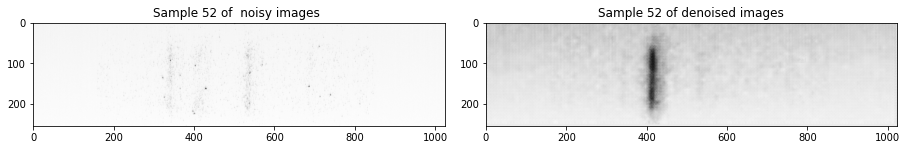

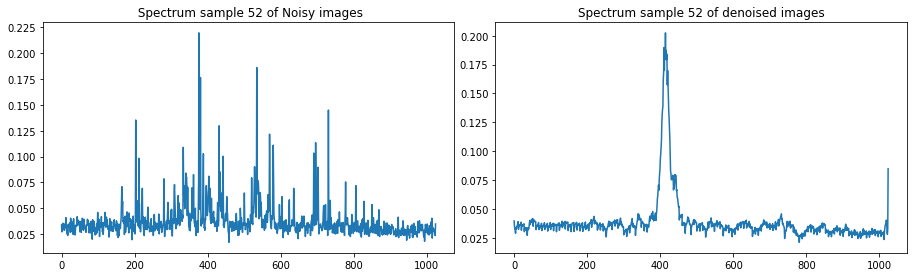

EPOCH 33 / 50
Partial Train loss is 0.0002727186365518719
Partial Train loss is 0.00030825770227238536
Partial Train loss is 0.00025495269801467657
Partial Train loss is 0.0002525403688196093
Partial Train loss is 0.0002676996518857777
Partial Train loss is 0.00024334223417099565
Partial Train loss is 0.00028706746525131166
Partial Train loss is 0.00025036302395164967
Partial Train loss is 0.0002516111417207867
Partial Train loss is 0.00030754940235055983
Partial Train loss is 0.00024997052969411016
Partial Train loss is 0.00023278403386939317
Partial Train loss is 0.00027973964461125433
Partial Train loss is 0.00028117248439230025
Partial Train loss is 0.00025313859805464745
Partial Train loss is 0.00023311049153562635
Partial Train loss is 0.0002559636195655912
Partial Train loss is 0.00024029352061916143
Partial Train loss is 0.00023837840126361698
Partial Train loss is 0.0002916216035373509
 
 Global  validation loss for this epoch  is 0.000355345691787079 

 EPOCH 33/50 	 train lo

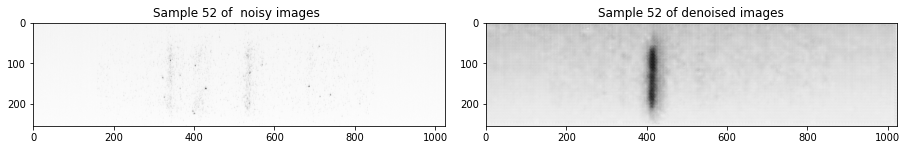

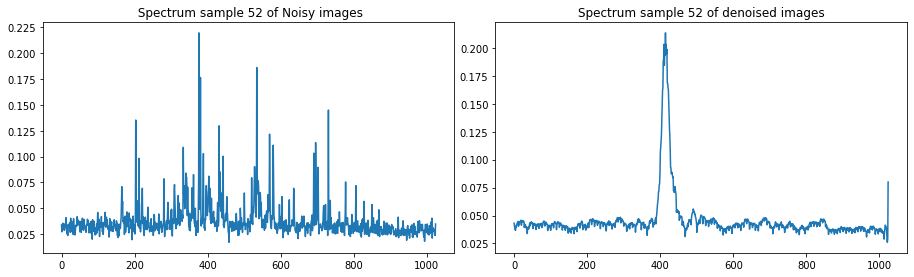

EPOCH 34 / 50
Partial Train loss is 0.00026976573280990124
Partial Train loss is 0.00030773712205700576
Partial Train loss is 0.00025109093985520303
Partial Train loss is 0.00025478407042101026
Partial Train loss is 0.000268698378931731
Partial Train loss is 0.0002400049561401829
Partial Train loss is 0.00028047861997038126
Partial Train loss is 0.00025293047656305134
Partial Train loss is 0.0002531928475946188
Partial Train loss is 0.000319112092256546
Partial Train loss is 0.00023570992925669998
Partial Train loss is 0.00023293602862395346
Partial Train loss is 0.00027430328191258013
Partial Train loss is 0.00027917884290218353
Partial Train loss is 0.0002499349066056311
Partial Train loss is 0.00023016314662527293
Partial Train loss is 0.0002512956561986357
Partial Train loss is 0.00023723012418486178
Partial Train loss is 0.00023506022989749908
Partial Train loss is 0.000295144971460104
 
 Global  validation loss for this epoch  is 0.0005089010228402913 

 EPOCH 34/50 	 train loss 

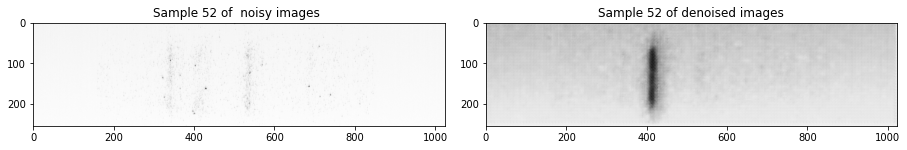

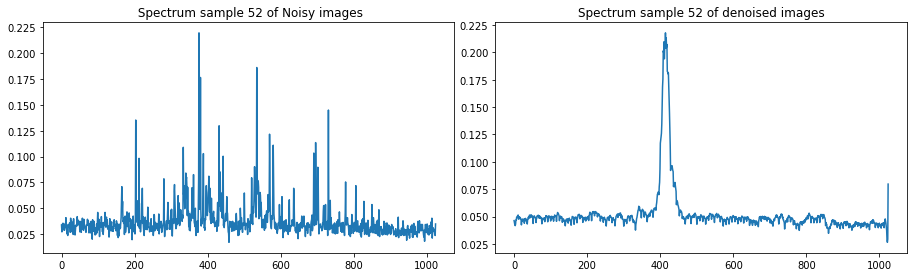

EPOCH 35 / 50
Partial Train loss is 0.0002719293115660548
Partial Train loss is 0.0003074470441788435
Partial Train loss is 0.0002512694918550551
Partial Train loss is 0.00024965908960439265
Partial Train loss is 0.0002691224217414856
Partial Train loss is 0.00023998846882022917
Partial Train loss is 0.00028484416543506086
Partial Train loss is 0.00025367806665599346
Partial Train loss is 0.00025098773767240345
Partial Train loss is 0.0003067244542762637
Partial Train loss is 0.000250036217039451
Partial Train loss is 0.00023178188712336123
Partial Train loss is 0.00027836119988933206
Partial Train loss is 0.0002778864582069218
Partial Train loss is 0.00025421808823011816
Partial Train loss is 0.00022898805036675185
Partial Train loss is 0.0002530344354454428
Partial Train loss is 0.00023666371998842806
Partial Train loss is 0.00023543844872619957
Partial Train loss is 0.0002916990779340267
 
 Global  validation loss for this epoch  is 0.0004939606296829879 

 EPOCH 35/50 	 train loss 

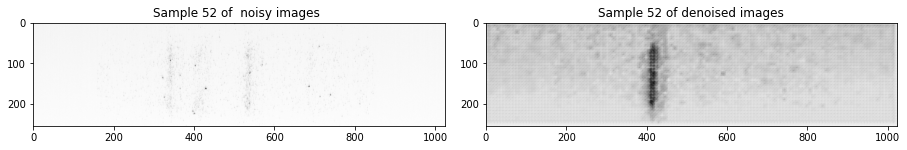

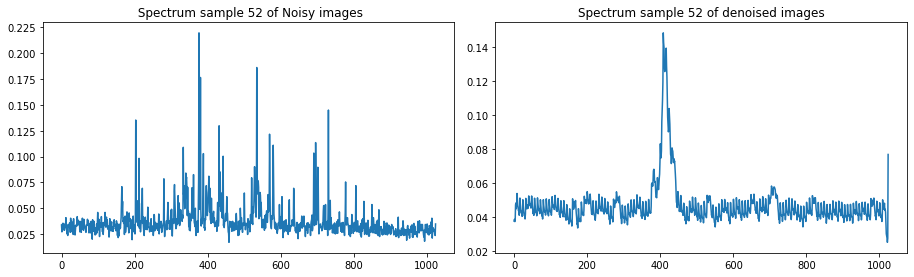

EPOCH 36 / 50
Partial Train loss is 0.00026604539016261697
Partial Train loss is 0.0003049583756364882
Partial Train loss is 0.00025614662445150316
Partial Train loss is 0.0002621848543640226
Partial Train loss is 0.0002714116999413818
Partial Train loss is 0.0002403563412372023
Partial Train loss is 0.0002820054942276329
Partial Train loss is 0.00026106697623617947
Partial Train loss is 0.0002539130800869316
Partial Train loss is 0.0003169052943121642
Partial Train loss is 0.00023515392967965454
Partial Train loss is 0.00023227476049214602
Partial Train loss is 0.0002683828060980886
Partial Train loss is 0.00027959770523011684
Partial Train loss is 0.0002515045343898237
Partial Train loss is 0.00022941660427022725
Partial Train loss is 0.00025077167083509266
Partial Train loss is 0.00023714732378721237
Partial Train loss is 0.00023391474678646773
Partial Train loss is 0.00029529142193496227
 
 Global  validation loss for this epoch  is 0.000637172139249742 

 EPOCH 36/50 	 train loss 

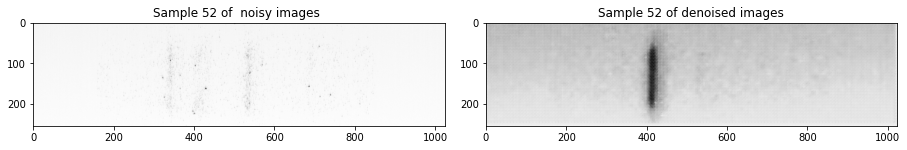

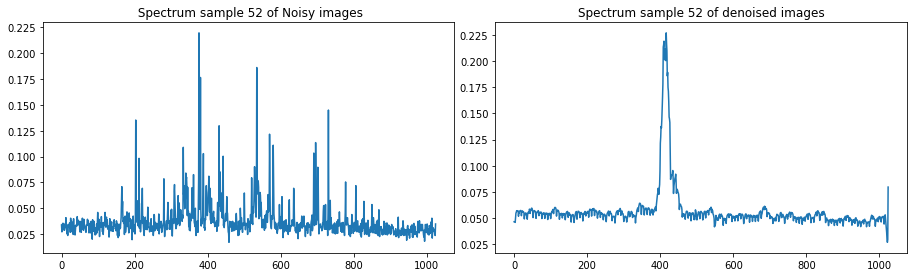

EPOCH 37 / 50
Partial Train loss is 0.00027042918372899294
Partial Train loss is 0.0003060835297219455
Partial Train loss is 0.00025251746410503983
Partial Train loss is 0.00025758970878086984
Partial Train loss is 0.0002716993913054466
Partial Train loss is 0.00023920286912471056
Partial Train loss is 0.00028268774622119963
Partial Train loss is 0.00025214909692294896
Partial Train loss is 0.0002506662276573479
Partial Train loss is 0.0003055434790439904
Partial Train loss is 0.0002516461245249957
Partial Train loss is 0.00023167218023445457
Partial Train loss is 0.00027874927036464214
Partial Train loss is 0.0002791044826153666
Partial Train loss is 0.00025190715678036213
Partial Train loss is 0.0002307534741703421
Partial Train loss is 0.0002529494813643396
Partial Train loss is 0.00023762532509863377
Partial Train loss is 0.0002354717580601573
Partial Train loss is 0.00028989207930862904
 
 Global  validation loss for this epoch  is 0.0002480961848050356 

 EPOCH 37/50 	 train loss

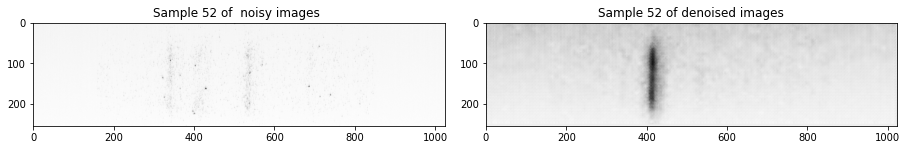

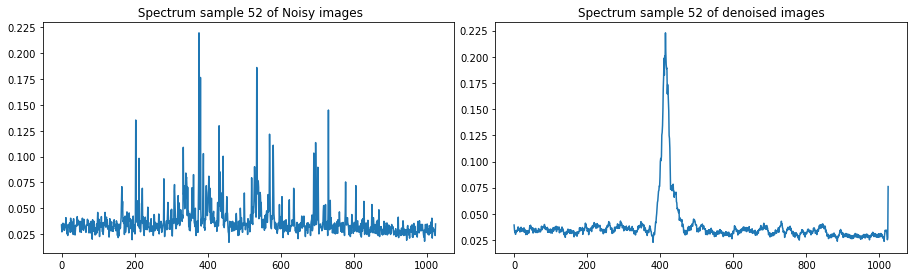

EPOCH 38 / 50
Partial Train loss is 0.00026680174050852656
Partial Train loss is 0.0003043975739274174
Partial Train loss is 0.0002528920886106789
Partial Train loss is 0.00025800379808060825
Partial Train loss is 0.000269601761829108
Partial Train loss is 0.00023763140779919922
Partial Train loss is 0.0002794530591927469
Partial Train loss is 0.0002544031012803316
Partial Train loss is 0.00025137467309832573
Partial Train loss is 0.00031355032115243375
Partial Train loss is 0.00023644771135877818
Partial Train loss is 0.00022956193424761295
Partial Train loss is 0.0002689232933335006
Partial Train loss is 0.0002756373432930559
Partial Train loss is 0.0002506262098904699
Partial Train loss is 0.00022655888460576534
Partial Train loss is 0.0002517605316825211
Partial Train loss is 0.00023511350445915014
Partial Train loss is 0.00023263208277057856
Partial Train loss is 0.0002914512006100267
 
 Global  validation loss for this epoch  is 0.00025820668088272214 

 EPOCH 38/50 	 train loss 

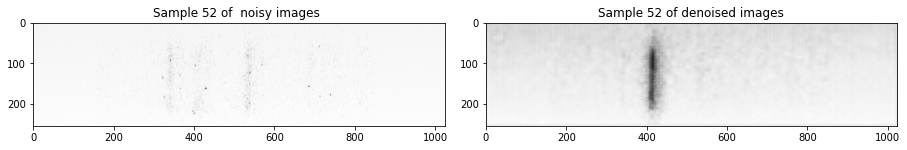

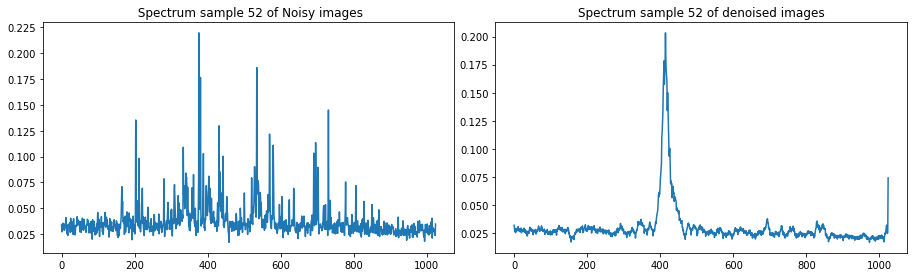

EPOCH 39 / 50
Partial Train loss is 0.00026656617410480976
Partial Train loss is 0.00030662567587569356
Partial Train loss is 0.0002505152951925993
Partial Train loss is 0.0002621730964165181
Partial Train loss is 0.00027325365226715803
Partial Train loss is 0.00024484246387146413
Partial Train loss is 0.0002838584186974913
Partial Train loss is 0.00025229001767002046
Partial Train loss is 0.0002499479160178453
Partial Train loss is 0.00030231030541472137
Partial Train loss is 0.00024838006356731057
Partial Train loss is 0.00022976989566814154
Partial Train loss is 0.0002709970867726952
Partial Train loss is 0.00027535876142792404
Partial Train loss is 0.00025002798065543175
Partial Train loss is 0.00022909951803740114
Partial Train loss is 0.0002521513670217246
Partial Train loss is 0.00023737600713502616
Partial Train loss is 0.00023394047457259148
Partial Train loss is 0.00029122826526872814
 
 Global  validation loss for this epoch  is 0.0002725413360167295 

 EPOCH 39/50 	 train l

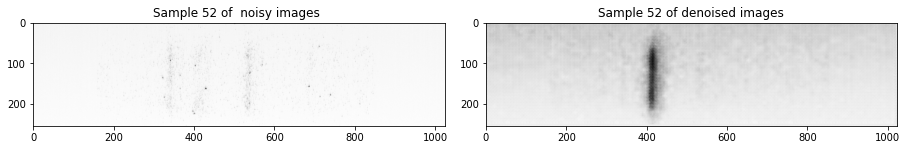

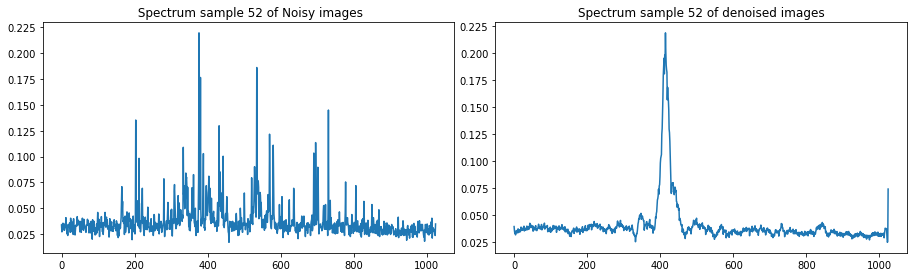

EPOCH 40 / 50
Partial Train loss is 0.00027593658887781203
Partial Train loss is 0.0003051866951864213
Partial Train loss is 0.00024599797325208783
Partial Train loss is 0.0002446967118885368
Partial Train loss is 0.00026564495055936277
Partial Train loss is 0.00023591921490151435
Partial Train loss is 0.00028101488715037704
Partial Train loss is 0.00024776122882030904
Partial Train loss is 0.0002494848158676177
Partial Train loss is 0.00030635419534519315
Partial Train loss is 0.00024597227456979454
Partial Train loss is 0.00022849917877465487
Partial Train loss is 0.00027390546165406704
Partial Train loss is 0.0002729857515078038
Partial Train loss is 0.00025640541571192443
Partial Train loss is 0.00022634193010162562
Partial Train loss is 0.0002578923595137894
Partial Train loss is 0.0002371783193666488
Partial Train loss is 0.00023862335365265608
Partial Train loss is 0.00029356087907217443
 
 Global  validation loss for this epoch  is 0.00047806251677684486 

 EPOCH 40/50 	 train 

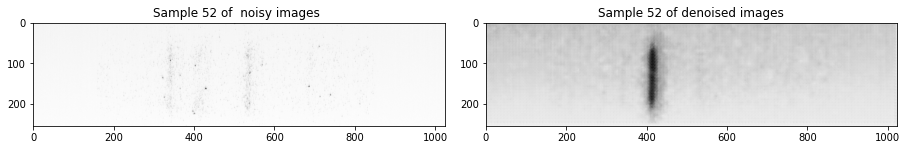

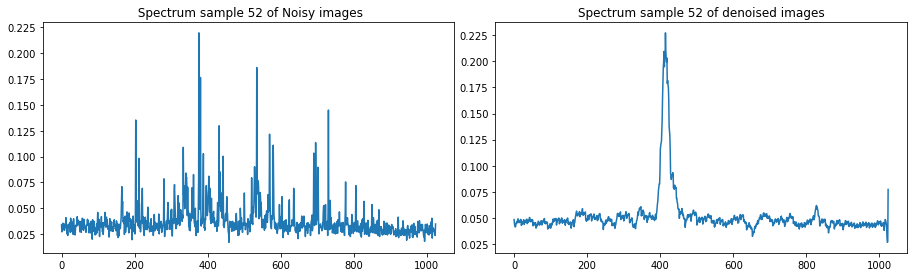

EPOCH 41 / 50
Partial Train loss is 0.00026850090944208205
Partial Train loss is 0.00030707017867825925
Partial Train loss is 0.00024988860241137445
Partial Train loss is 0.0002548870106693357
Partial Train loss is 0.00027012047939933836
Partial Train loss is 0.0002412007743259892
Partial Train loss is 0.0002830284647643566
Partial Train loss is 0.00025651458417996764
Partial Train loss is 0.00025064844521693885
Partial Train loss is 0.00031009764643386006
Partial Train loss is 0.00023620850697625428
Partial Train loss is 0.00022916021407581866
Partial Train loss is 0.0002667433873284608
Partial Train loss is 0.0002739490591920912
Partial Train loss is 0.000249788659857586
Partial Train loss is 0.00022824716870673
Partial Train loss is 0.0002524240408092737
Partial Train loss is 0.00023766738013364375
Partial Train loss is 0.0002350322756683454
Partial Train loss is 0.00029531700420193374
 
 Global  validation loss for this epoch  is 0.000328434252878651 

 EPOCH 41/50 	 train loss 0.0

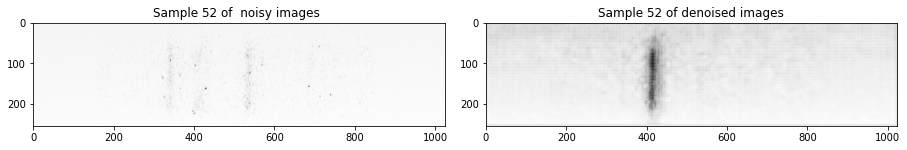

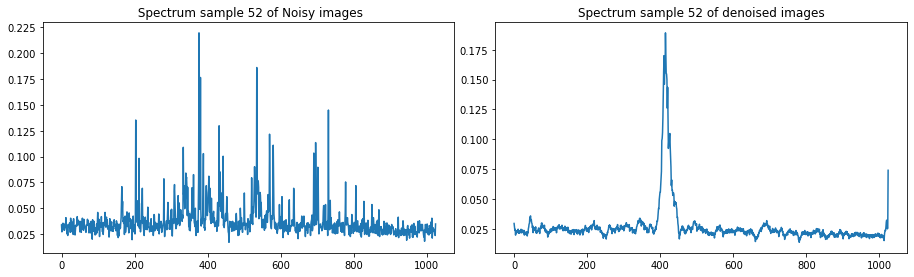

EPOCH 42 / 50
Partial Train loss is 0.00026513877674005926
Partial Train loss is 0.0003048338694497943
Partial Train loss is 0.0002575116523075849
Partial Train loss is 0.0002661289763636887
Partial Train loss is 0.00027437633252702653
Partial Train loss is 0.00024011940695345402
Partial Train loss is 0.00028122603544034064
Partial Train loss is 0.00026084372075274587
Partial Train loss is 0.00025161184021271765
Partial Train loss is 0.0003127061063423753
Partial Train loss is 0.00023660599254071712
Partial Train loss is 0.00023047519789543003
Partial Train loss is 0.00026563098072074354
Partial Train loss is 0.0002762787917163223
Partial Train loss is 0.00024724091053940356
Partial Train loss is 0.00022717553656548262
Partial Train loss is 0.0002504264411982149
Partial Train loss is 0.00023582026187796146
Partial Train loss is 0.00023206431069411337
Partial Train loss is 0.0002946222375612706
 
 Global  validation loss for this epoch  is 0.0003428347408771515 

 EPOCH 42/50 	 train lo

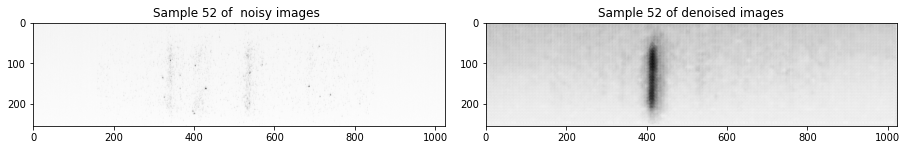

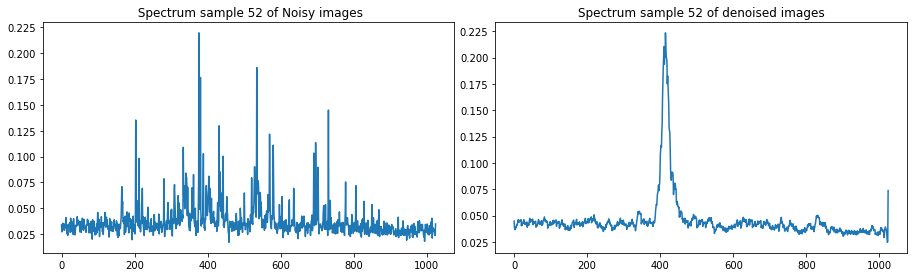

EPOCH 43 / 50
Partial Train loss is 0.0002701858466025442
Partial Train loss is 0.00030384858837351203
Partial Train loss is 0.0002477110829204321
Partial Train loss is 0.00025383965112268925
Partial Train loss is 0.00026678162976168096
Partial Train loss is 0.00023786524252500385
Partial Train loss is 0.00028012716211378574
Partial Train loss is 0.0002517170796636492
Partial Train loss is 0.0002500040573067963
Partial Train loss is 0.00030517714913003147
Partial Train loss is 0.00025215325877070427
Partial Train loss is 0.00023049388255458325
Partial Train loss is 0.00027654654695652425
Partial Train loss is 0.00027650868287310004
Partial Train loss is 0.0002560175198595971
Partial Train loss is 0.00022800013539381325
Partial Train loss is 0.00025624127010814846
Partial Train loss is 0.00023883870744612068
Partial Train loss is 0.00023618554405402392
Partial Train loss is 0.0002863515692297369
 
 Global  validation loss for this epoch  is 0.00029865308897569776 

 EPOCH 43/50 	 train 

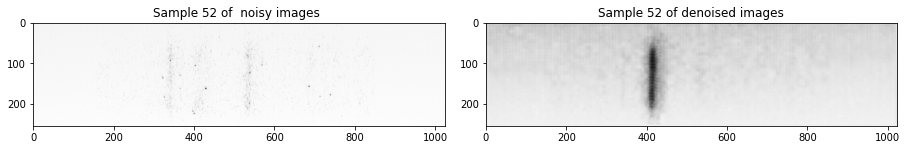

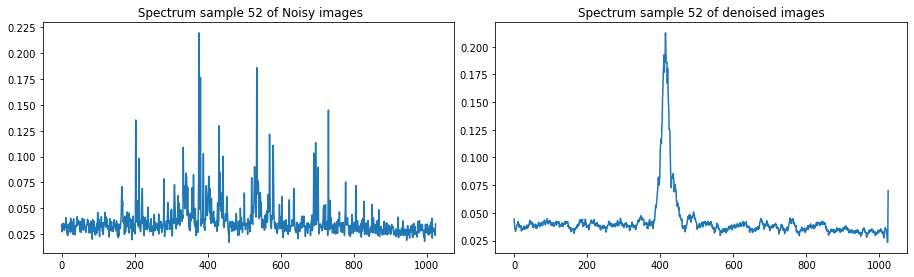

EPOCH 44 / 50
Partial Train loss is 0.0002664760686457157
Partial Train loss is 0.00030350105953402817
Partial Train loss is 0.00025253681815229356
Partial Train loss is 0.00025818805443122983
Partial Train loss is 0.0002692072303034365
Partial Train loss is 0.00023787646205164492
Partial Train loss is 0.00027915212558582425
Partial Train loss is 0.00025471538538113236
Partial Train loss is 0.00025040344917215407
Partial Train loss is 0.0003064769844058901
Partial Train loss is 0.0002341256767977029
Partial Train loss is 0.00022919882030691952
Partial Train loss is 0.0002632213581819087
Partial Train loss is 0.0002711632987484336
Partial Train loss is 0.00024662315263412893
Partial Train loss is 0.00022548859124071896
Partial Train loss is 0.00024904057499952614
Partial Train loss is 0.0002342602238059044
Partial Train loss is 0.0002322140207979828
Partial Train loss is 0.0002953552466351539
 
 Global  validation loss for this epoch  is 0.0004968552384525537 

 EPOCH 44/50 	 train loss

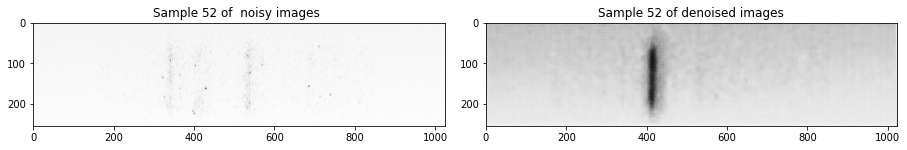

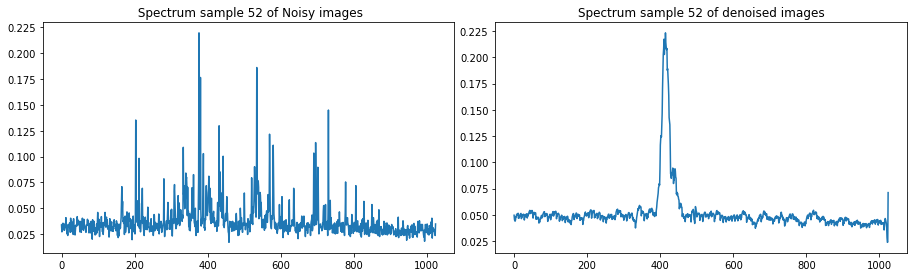

EPOCH 45 / 50
Partial Train loss is 0.00026799418264999986
Partial Train loss is 0.00030339221120812
Partial Train loss is 0.00025044690119102597
Partial Train loss is 0.00025562342489138246
Partial Train loss is 0.00026581442216411233
Partial Train loss is 0.0002371410810155794
Partial Train loss is 0.0002793313469737768
Partial Train loss is 0.000253540463745594
Partial Train loss is 0.0002488561731297523
Partial Train loss is 0.0003092129190918058
Partial Train loss is 0.00024319463409483433
Partial Train loss is 0.00022766819165553898
Partial Train loss is 0.0002702015044633299
Partial Train loss is 0.00027438823599368334
Partial Train loss is 0.00025046017253771424
Partial Train loss is 0.00022690252808388323
Partial Train loss is 0.000253133854130283
Partial Train loss is 0.00023635546676814556
Partial Train loss is 0.00023640361905563623
Partial Train loss is 0.00029614026425406337
 
 Global  validation loss for this epoch  is 0.00030734518077224493 

 EPOCH 45/50 	 train loss 0

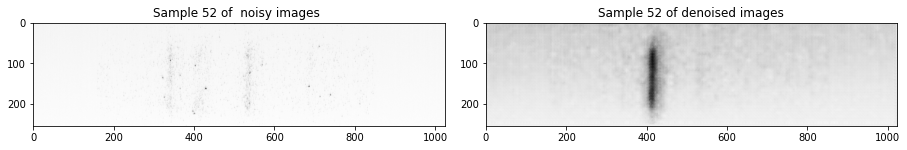

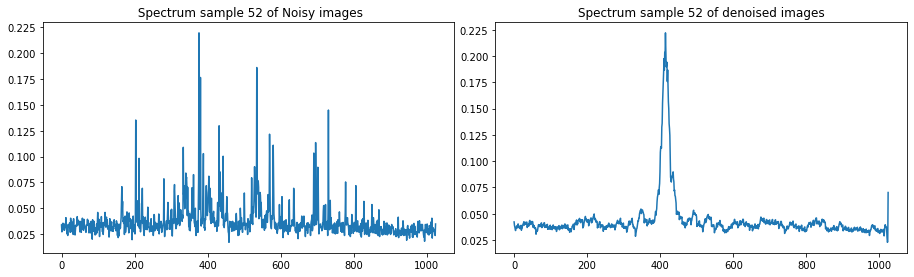

EPOCH 46 / 50
Partial Train loss is 0.0002651230606716126
Partial Train loss is 0.000309388356981799
Partial Train loss is 0.0002542809525039047
Partial Train loss is 0.0002575972757767886
Partial Train loss is 0.0002727832179516554
Partial Train loss is 0.00023886880080681294
Partial Train loss is 0.0002824164694175124
Partial Train loss is 0.000265176611719653
Partial Train loss is 0.00025181175442412496
Partial Train loss is 0.0003180059720762074
Partial Train loss is 0.00023429215070791543
Partial Train loss is 0.00023161584977060556
Partial Train loss is 0.0002659946621861309
Partial Train loss is 0.00027372772456146777
Partial Train loss is 0.0002476386143825948
Partial Train loss is 0.00022826121130492538
Partial Train loss is 0.000249899661866948
Partial Train loss is 0.00023625469475518912
Partial Train loss is 0.00023348275863099843
Partial Train loss is 0.00029911744059063494
 
 Global  validation loss for this epoch  is 0.00023931679606903344 

 EPOCH 46/50 	 train loss 0.0

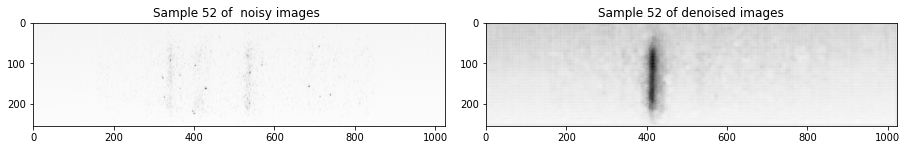

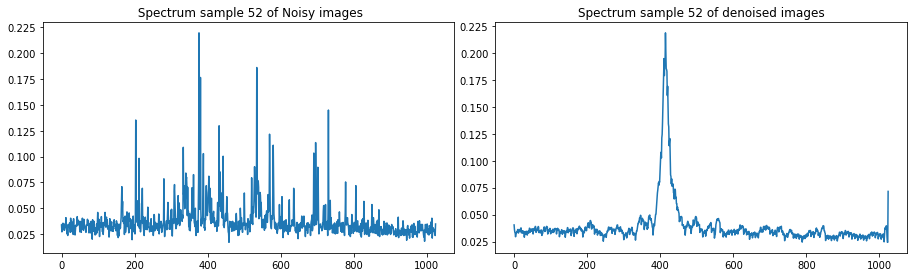

EPOCH 47 / 50
Partial Train loss is 0.00026580883422866464
Partial Train loss is 0.00030351674649864435
Partial Train loss is 0.0002549742057453841
Partial Train loss is 0.00025583835667930543
Partial Train loss is 0.0002689304237719625
Partial Train loss is 0.00023837157641537488
Partial Train loss is 0.0002795515756588429
Partial Train loss is 0.0002559703716542572
Partial Train loss is 0.00024957171990536153
Partial Train loss is 0.0003103753551840782
Partial Train loss is 0.00024113641120493412
Partial Train loss is 0.0002294783917022869
Partial Train loss is 0.0002674513962119818
Partial Train loss is 0.0002736479218583554
Partial Train loss is 0.0002486847806721926
Partial Train loss is 0.00022647307196166366
Partial Train loss is 0.00025116614415310323
Partial Train loss is 0.0002359644277021289
Partial Train loss is 0.00023495208006352186
Partial Train loss is 0.00029799918411299586
 
 Global  validation loss for this epoch  is 0.0002295211306773126 

 EPOCH 47/50 	 train loss 

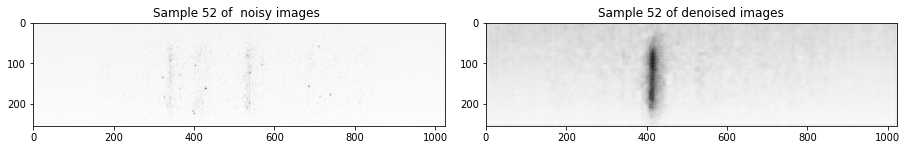

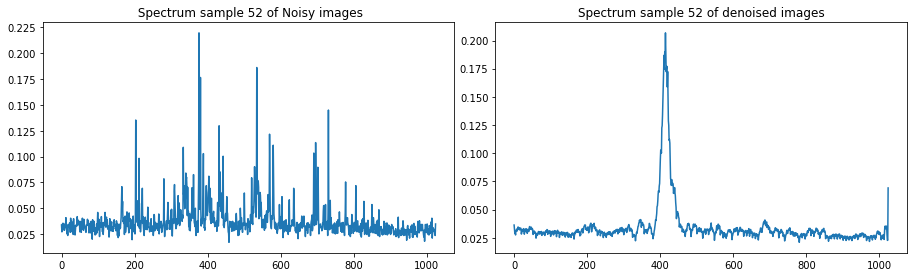

EPOCH 48 / 50
Partial Train loss is 0.0002657868608366698
Partial Train loss is 0.00030765755218453705
Partial Train loss is 0.00025628041476011276
Partial Train loss is 0.00025459926109761
Partial Train loss is 0.00027014760416932404
Partial Train loss is 0.00024061980366241187
Partial Train loss is 0.00028269621543586254
Partial Train loss is 0.0002588982169982046
Partial Train loss is 0.0002515422529540956
Partial Train loss is 0.00031342398142442107
Partial Train loss is 0.0002416697097942233
Partial Train loss is 0.0002305474627064541
Partial Train loss is 0.0002675549185369164
Partial Train loss is 0.0002724164805840701
Partial Train loss is 0.0002503360447008163
Partial Train loss is 0.00022629860904999077
Partial Train loss is 0.00025098081096075475
Partial Train loss is 0.0002359692007303238
Partial Train loss is 0.00023449525178875774
Partial Train loss is 0.00029420314240269363
 
 Global  validation loss for this epoch  is 0.0002466683217789978 

 EPOCH 48/50 	 train loss 0.

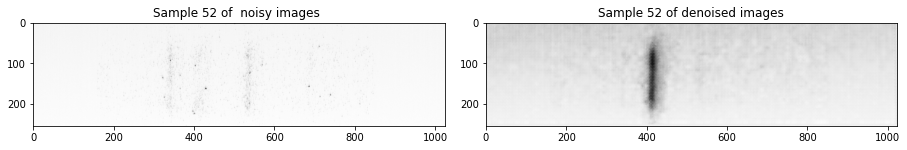

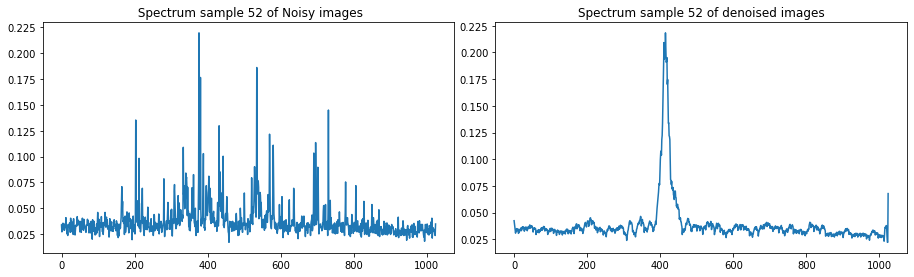

EPOCH 49 / 50
Partial Train loss is 0.0002645647618919611
Partial Train loss is 0.00030348883592523634
Partial Train loss is 0.0002584995818324387
Partial Train loss is 0.00026005119434557855
Partial Train loss is 0.00026997271925210953
Partial Train loss is 0.00023846063413657248
Partial Train loss is 0.0002800911315716803
Partial Train loss is 0.0002610448864288628
Partial Train loss is 0.0002496129018254578
Partial Train loss is 0.00030679424526169896
Partial Train loss is 0.00024487898917868733
Partial Train loss is 0.0002304340450791642
Partial Train loss is 0.0002679548633750528
Partial Train loss is 0.0002724956430029124
Partial Train loss is 0.00024945769109763205
Partial Train loss is 0.00022620339586865157
Partial Train loss is 0.00025033607380464673
Partial Train loss is 0.00023489518207497895
Partial Train loss is 0.0002336868055863306
Partial Train loss is 0.00029360043117776513
 
 Global  validation loss for this epoch  is 0.00037879039882682264 

 EPOCH 49/50 	 train los

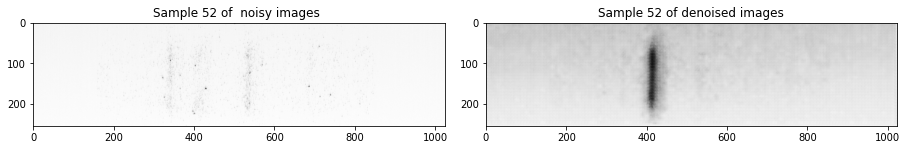

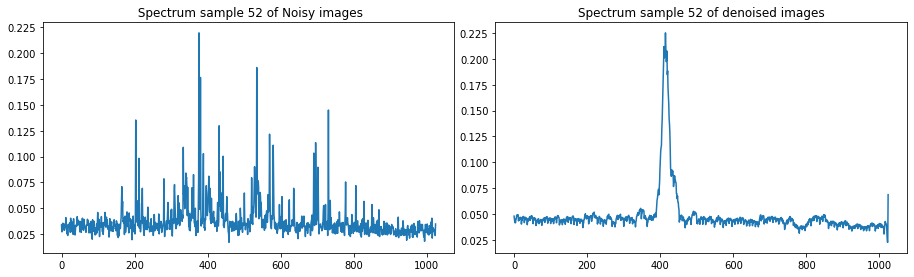

EPOCH 50 / 50
Partial Train loss is 0.00026560304104350507
Partial Train loss is 0.0003045210032723844
Partial Train loss is 0.00025329930940642953
Partial Train loss is 0.00025452414411120117
Partial Train loss is 0.0002686938678380102
Partial Train loss is 0.0002385487750871107
Partial Train loss is 0.00028080097399652004
Partial Train loss is 0.0002546854375395924
Partial Train loss is 0.00025086611276492476
Partial Train loss is 0.0003059055597987026
Partial Train loss is 0.0002408170112175867
Partial Train loss is 0.00022898461611475796
Partial Train loss is 0.00026708183577284217
Partial Train loss is 0.0002711276465561241
Partial Train loss is 0.0002498762041795999
Partial Train loss is 0.000227869299123995
Partial Train loss is 0.000251412478974089
Partial Train loss is 0.00023635882826056331
Partial Train loss is 0.00023642367159482092
Partial Train loss is 0.00029740584432147443
 
 Global  validation loss for this epoch  is 0.0003225991385988891 

 EPOCH 50/50 	 train loss 0.

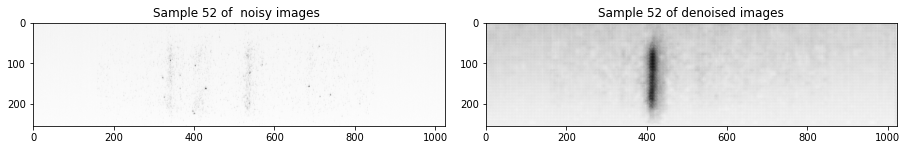

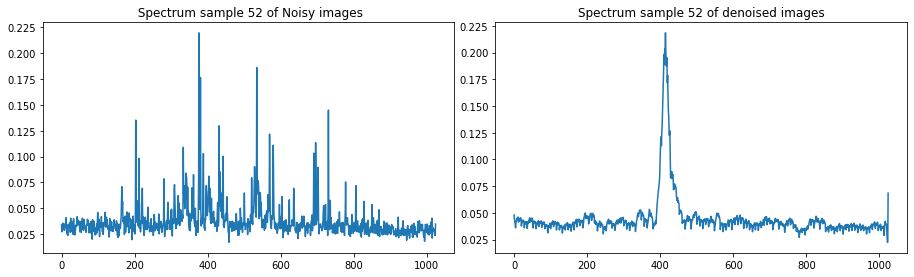

In [17]:
### Training cycle
## For each epoch, we call the training function and validation function and at the end we apply the DAE on our noisy images and show the results
num_epochs = 50
history_da={'train_loss':[],'val_loss':[]}
train_losss,vali_losses=[],[]
for epoch in range(num_epochs):
    print('EPOCH {} / {}'.format(epoch + 1, num_epochs))
    ### Training (use the training function)
    train_loss=train_epoch_den(
        encoder=encoder, 
        decoder=decoder, 
        device=device, 
        dataloader=train_loader, 
        loss_fn=loss_fn, 
        optimizer=optim,
        noise_fac=noise_factor)
    ### Validation  (use the validation function)
    val_loss = vali_epoch_den(
        encoder=encoder, 
        decoder=decoder, 
        device=device, 
        dataloader=valid_loader, 
        loss_fn=loss_fn,
        noise_fac=noise_factor)
    # Print Validation loss
    #history_da['train_loss'].append(train_loss)
    #history_da['val_loss'].append(val_loss)
    train_losss.append(train_loss)
    vali_losses.append(val_loss)
    print('\n EPOCH {}/{} \t train loss {:.3f} \t val loss {:.3f}'.format(epoch + 1, num_epochs,train_loss,val_loss))
    denoised=plotting(test_dataset,encoder,decoder,rand) # appling the DAE on our noisy images
    
    
    
    

# Final Analysis


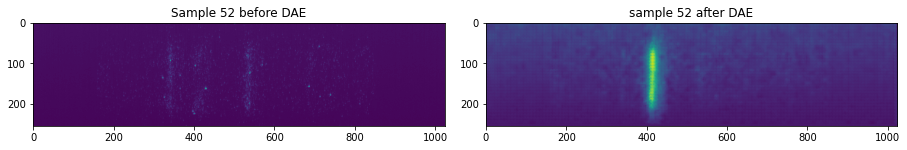

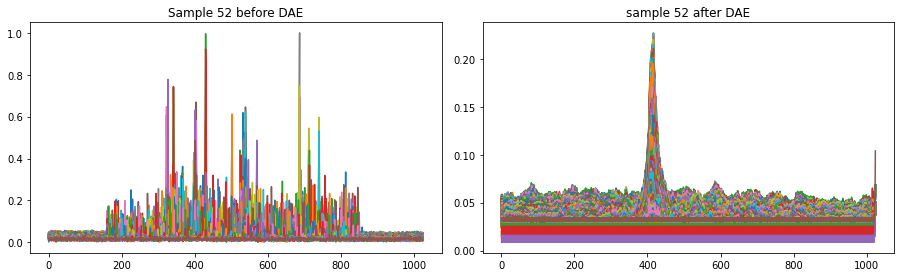

In [18]:
# showing the final results after the last epoch but this time images are in original colormap ( previous one were binary) 
final=denoised#.cpu().permute(0,2,3,1).squeeze().numpy()
for i in range(1):
    plt.subplot(1,2,2)
    plt.imshow(final[rand+i])
    plt.title('sample {} after DAE'.format(rand+i))
    plt.subplot(1,2,1)
    plt.imshow(noise[rand+i])
    plt.title('Sample {} before DAE'.format(rand+i))
    plt.subplots_adjust(left=1,
                    bottom=0.1, 
                    right=3, 
                    top=0.9, 
                    wspace=0.1, 
                    hspace=0.2) 
    plt.show()
    
    
    
x=np.linspace(0,1024,1024)
for i in range(1):
    for j in range(256):
        
        plt.subplot(1,2,2)
        plt.plot(x,denoised[rand+i][j])
        plt.title('sample {} after DAE'.format(rand+i))
        plt.subplot(1,2,1)
        plt.plot(x,noise[rand+i][j])
        plt.title('Sample {} before DAE'.format(rand+i))
        plt.subplots_adjust(left=1,
                    bottom=0.1, 
                    right=3, 
                    top=0.9, 
                    wspace=0.1, 
                    hspace=0.2) 
    plt.show()

(0.0, 0.01)

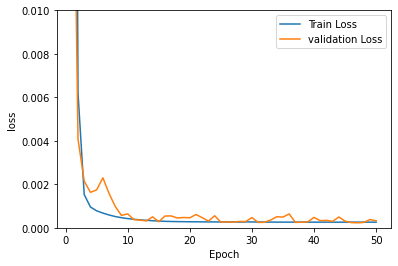

In [19]:
plt.plot(np.linspace(1,epoch+1,epoch+1),train_losss,label='Train Loss')
plt.plot(np.linspace(1,epoch+1,epoch+1),vali_losses,label='validation Loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.legend()
plt.ylim(0,10**(-2))

/tmp/ipykernel_666/1581149244.py:88: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Mnd1= np.asarray(Mnd)
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/numpy/core/_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/numpy/core

Relative error at center of capillary: 0.04559321373353566


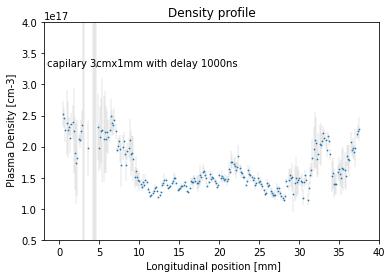

In [20]:
# and here, by fitting , we measure the density and plot the density profile
post_anal, dc, tk= main(denoised)
beaut(post_anal, dc, tk)